# Philo Online Assessment for Sr. Data Scientist 

__Contributor__: Sanaz Behbahani

__Date__: May 2024

# Problem Description

In the TV Subscription business the legacy pattern of cable and satellite companies was to lock people in with hardware and multi-year contracts. 
With the growth of streaming and the variety of streaming services available “churn and return” is an increasingly common pattern as services can easily be started and cancelled on a relatively frequent cadence.

In this exercise based off of some modified, but real, data we are asking you to review a data set that was pulled to consider retention/churn behavior of a cohort of users. 
Given that this is generated from actual product data, there may not be a clear and obvious solution, so don’t be concerned if you aren’t seeing any one thing stand out. 
Our Product team is interested in learning about any interesting behaviors or attributes of the accounts: 

1. that are retained for multiple consecutive months, 
2. that churn rapidly, or 
3. that cancel and restart in a short period of time.

To simplify this analysis for the purposes of an interview we have generated a small subset of accounts, along with a subset of product and usage attributes and we are focused on a singly cohort in a relatively short period of time.

The csv file we are providing is a random sample of the accounts that were identified as new subscribers in “January 2023” (”quotes” because this is pseudo-real).
We ask that you generate some analysis on this random sample.
You can expect that the person reviewing this is a data scientist and thus will be familiar with statistical concepts and 
that they will want to be able to review and re-run any code you use on the full dataset we have from which this sample was drawn.

We would recommend that you write any analyses in R or Python, but if there is another non-proprietary language that is more suitable for your analysis you can use that as long as we will be able to run your code on the full dataset. 

We are not looking for a proof of an optimal solution, but instead how you begin the 
process of investigating a problem and how you communicate that in code and in the initial summary of findings.
Our expectation is that you spend a few hours on this and not multiple days so we will be evaluating your work with that in mind.
There will be interesting avenues of investigation that you choose not to go down, you can also note that in your answer indicating that with additional time these are areas you would evaluate further.

You are free to build off of work and software packages that other analysts, data scientists, or engineers have built, we simply ask you to reference their work where you use it (concept or code).

## 1. Initial data exploration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast

from collections import Counter
from IPython.display import display
from sklearn.impute import KNNImputer
from pylab import rcParams
from pathlib import Path

In [2]:
# Set default figure size
rcParams['figure.figsize'] = (10, 6)

# Display floats to two decimals
pd.options.display.float_format = "{:,.2f}".format

In [3]:
path = 'subscriber_data_exercise__candidate_set.csv'

In [4]:
data = pd.read_csv(path, sep=',')
data.head()

,account_id,last_billing_platform_used,last_subscription_status,created_at,dma_code,dma_region,dma_name,age_range,has_email,has_phone,...,trial_started_at,trial_ended_at,acquisition_biller,signup_platform,distinct_channels,distinct_shows,hours_watched,shows_saved,stream_starts,payment_months
0,140477,external_a,regular,12/25/22 5:19,NaN,NaN,NaN,NaN,True,False,...,12/25/22 5:19,1/1/23 5:19,external_a,tv_platform_c,31.00,95.00,"1,522.58",3.00,"1,104.00","2023-01-01 00:00:00, 2023-02-01 00:00:00, 2023..."
1,179440,external_b,deactivated,1/1/23 20:07,NaN,NaN,NaN,NaN,True,True,...,1/1/23 21:27,1/8/23 21:27,external_b,mobile_b,22.00,41.00,17.05,0.00,48.00,1/1/23 0:00
2,156674,external_b,regular,4/23/22 19:06,NaN,NaN,NaN,NaN,True,True,...,4/23/22 19:07,4/30/22 19:07,external_b,tv_platform_e,6.00,9.00,56.79,1.00,50.00,"2023-01-01 00:00:00, 2023-02-01 00:00:00, 2023..."
3,118395,internal_a,regular,1/15/23 2:35,675.00,NaN,PEORIA-BLOOMINGTON,NaN,True,True,...,1/15/23 18:47,1/22/23 18:47,internal_a,mobile_web_b,5.00,8.00,1.78,0.00,100.00,"2023-01-01 00:00:00, 2023-02-01 00:00:00, 2023..."
4,222101,external_a,deactivated,11/28/22 19:14,NaN,NaN,NaN,NaN,True,False,...,11/28/22 19:16,1/13/23 16:14,external_a,tv_platform_c,NaN,NaN,NaN,NaN,NaN,1/1/23 0:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31461 entries, 0 to 31460
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   account_id                         31461 non-null  int64  
 1   last_billing_platform_used         31461 non-null  object 
 2   last_subscription_status           31461 non-null  object 
 3   created_at                         31461 non-null  object 
 4   dma_code                           18409 non-null  float64
 5   dma_region                         7 non-null      object 
 6   dma_name                           18409 non-null  object 
 7   age_range                          6 non-null      object 
 8   has_email                          31461 non-null  bool   
 9   has_phone                          31461 non-null  bool   
 10  direct_billed                      15910 non-null  object 
 11  demographic_gender                 340 non-null    obj

In [6]:
# Dataset Duplicate Value Count
data.duplicated().sum()

0

In [7]:
missing = data.isnull().sum(axis=0)
missing.name = 'Missing'
missing = missing.to_frame()
missing = missing[missing['Missing'] > 0]
# Calculate missing percentage
missing['Missing Percentage'] = (missing['Missing'] / data.shape[0]) * 100
missing.sort_values('Missing', ascending=False)

,Missing,Missing Percentage
age_range,31455,99.98
dma_region,31454,99.98
demographic_age_range,31202,99.18
demographic_homeowner,31146,99.00
demographic_gender,31121,98.92
demographic_household_composition,31120,98.92
demographic_education_level,31110,98.88
demographic_income,31109,98.88
demographic_people_in_household,31082,98.80
total_refunded,30281,96.25


<Axes: >

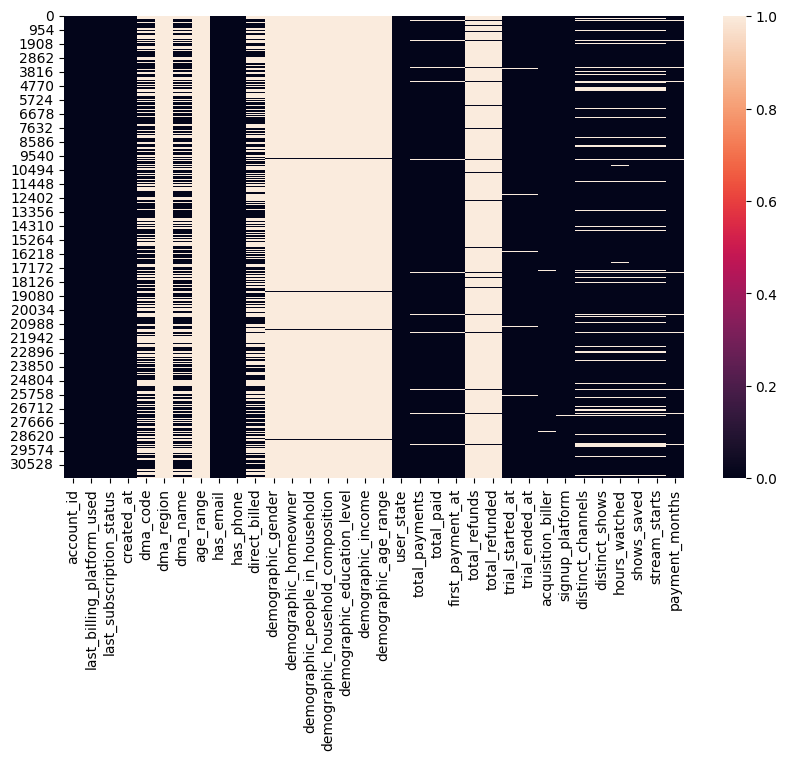

In [8]:
# Visualizing the missing values
sns.heatmap(data.isnull())

In [9]:
data.describe()

,account_id,dma_code,demographic_people_in_household,demographic_income,total_payments,total_paid,total_refunds,total_refunded,distinct_channels,distinct_shows,hours_watched,shows_saved,stream_starts
count,"31,461.00","18,409.00",379.00,352.00,"30,631.00","30,631.00","1,180.00","1,180.00","28,443.00","28,443.00","28,274.00","28,443.00","28,443.00"
mean,"179,561.33",618.98,2.66,"68,028.41",2.46,63.46,1.04,27.64,5.94,14.04,96.99,2.25,98.29
std,"45,899.14",106.66,2.12,"58,059.50",1.20,31.40,0.23,7.17,6.83,25.00,260.93,7.46,169.19
min,"100,002.00",500.00,0.00,"1,000.00",1.00,3.00,1.00,12.00,0.00,0.00,-81.03,0.00,0.00
25%,"139,988.00",524.00,1.00,"25,000.00",1.00,26.75,1.00,25.00,1.00,2.00,8.01,0.00,14.00
50%,"179,674.00",602.00,2.00,"55,000.00",3.00,74.97,1.00,26.00,3.00,4.00,22.07,0.00,39.00
75%,"219,732.00",679.00,4.00,"95,000.00",4.00,92.98,1.00,27.00,8.00,14.00,74.11,2.00,109.00
max,"258,436.00",881.00,8.00,"250,000.00",20.00,413.12,3.00,87.00,69.00,431.00,"7,021.18",510.00,"3,896.00"


#### Observations

1. __Missing Values__:
    * The dataset exhibits a significant number of missing values, notably in columns such as "dma_region," "age_range," "demographic_gender," "demographic_homeowner," "demographic_people_in_household," "demographic_household_composition," "demographic_education_level," "demographic_income," "demographic_age_range," "total_refunds," and "total_refunded." These columns show a data absence exceeding 90%.
    * Columns such as "dma_code," "dma_name," and "direct_billed" show approximately 50% missing data.
2. __Outliers__:
    * Several columns, including "stream_starts," "shows_saved," "hours_watched," and "distinct_shows," include extreme outlier values. These outliers may skew statistical analyses and should be carefully considered during data preprocessing.
3. __Negative Values__:
    * An anomaly is observed in the "hours_watched" column, where negative values are present. This requires further investigation to understand the cause of these discrepancies and to ensure data integrity.

## 2. Handle missing values

An initial assessment of missing values revealed several columns with significant data absence. To ensure the quality and reliability of the analysis, a data cleaning process was implemented.

___Missing Value Thresholds___:

Columns with missing data exceeding a predefined threshold of 40% were excluded from the analysis. This decision was based on the assumption that columns with such a high proportion of missing values would likely not contribute meaningful insights due to the limited available data.

The choice of the 40% threshold was based on a thorough assessment of the missing value distribution within the dataset. 
This threshold ensures that only columns with a reasonably complete set of data are considered for further analysis.

In [10]:
# Calculate percentage of missing values for each column
missing_percentage = data.isnull().mean() * 100

# Columns with missing percentage greater than 40%
threshold = 40
sparse_features = missing_percentage[missing_percentage > threshold].index
print("Sparse Features:")
print(sparse_features)

# Remove sparse features from the dataset
data_cleaned = data.drop(columns=sparse_features)

# Print updated dataset info after removing sparse columns
print("\nUpdated DataFrame Info:")
print(data_cleaned.info())

Sparse Features:
Index(['dma_code', 'dma_region', 'dma_name', 'age_range', 'direct_billed',
       'demographic_gender', 'demographic_homeowner',
       'demographic_people_in_household', 'demographic_household_composition',
       'demographic_education_level', 'demographic_income',
       'demographic_age_range', 'total_refunds', 'total_refunded'],
      dtype='object')

Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31461 entries, 0 to 31460
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  31461 non-null  int64  
 1   last_billing_platform_used  31461 non-null  object 
 2   last_subscription_status    31461 non-null  object 
 3   created_at                  31461 non-null  object 
 4   has_email                   31461 non-null  bool   
 5   has_phone                   31461 non-null  bool   
 6   user_state                  31

## 3. Further assessment of columns

### Categorical columns statistics

Inspect categorical columns to make sure they contain "valid" values.
I will remove the columns containing dates for this analysis.


In [11]:
categorical = data_cleaned.select_dtypes('object').columns
categorical = categorical.to_list()
omit = ['first_payment_at', 'payment_months', 'trial_started_at', 'trial_ended_at', 'created_at']
colors = plt.get_cmap('tab20').colors

for col in categorical:
    if col not in omit:
        tmp = data_cleaned[['account_id', col]].copy()
        tmp = tmp.fillna('NaN')
        tmp = tmp.groupby(col, as_index=False)
        tmp = tmp.count()
        tmp = tmp.rename(columns={'account_id': 'Count'})
        tmp = tmp.sort_values('Count', ascending=False)
        tmp = tmp.reset_index(drop=True)
        display(tmp)

,last_billing_platform_used,Count
0,internal_a,17603
1,external_a,5548
2,external_b,4540
3,external_c,3762
4,internal_b,8


,last_subscription_status,Count
0,deactivated,15824
1,regular,13568
2,departing,1229
3,delinquent_access,493
4,deleted,166
5,delinquent_no_access,157
6,lapsed,21
7,locked_out,2
8,blocked,1


,user_state,Count
0,Active,15472
1,Churned,15159
2,Refunded,830


,acquisition_biller,Count
0,internal_a,17515
1,external_a,5402
2,external_b,4155
3,external_c,3681
4,internal_b,527
5,NaN,179
6,external_d,2


,signup_platform,Count
0,mobile_web_b,8852
1,tv_platform_c,6061
2,tv_platform_e,4137
3,mobile_b,3785
4,mobile_web_a,3543
5,web,3505
6,tv_platform_g,494
7,mobile_a,491
8,tv_platform_a,435
9,NaN,90


### Numerical columns statistics

In [12]:
data_cleaned.describe()

,account_id,total_payments,total_paid,distinct_channels,distinct_shows,hours_watched,shows_saved,stream_starts
count,"31,461.00","30,631.00","30,631.00","28,443.00","28,443.00","28,274.00","28,443.00","28,443.00"
mean,"179,561.33",2.46,63.46,5.94,14.04,96.99,2.25,98.29
std,"45,899.14",1.20,31.40,6.83,25.00,260.93,7.46,169.19
min,"100,002.00",1.00,3.00,0.00,0.00,-81.03,0.00,0.00
25%,"139,988.00",1.00,26.75,1.00,2.00,8.01,0.00,14.00
50%,"179,674.00",3.00,74.97,3.00,4.00,22.07,0.00,39.00
75%,"219,732.00",4.00,92.98,8.00,14.00,74.11,2.00,109.00
max,"258,436.00",20.00,413.12,69.00,431.00,"7,021.18",510.00,"3,896.00"


### Observations

The initial exploration of numerical columns identified negative values within the "hours_watched" column. 
These negative values are considered data errors and addressed using the following approach:

___Outlier Detection___:  
Since "hours_watched" represents the number of hours viewed during the first subscription month, a reasonable upper and lower bound is determined by assuming a 31-day month with 24 hours per day, resulting in a maximum possible value of 744 hours and minimum value of 0 hours. 
Data points outside these thresholds are classified as outliers.

___Outlier Handling___:
To address these outliers, I have decided to remove the data points. 
This decision was based on the assumption that these outliers potentially stemmed from recording errors.

___Impact of Cleaning___:  
The data cleaning process resulted in the removal of outlier data points, leading to a reduction in the overall dataset size to 27496 rows.

In [13]:
# Removing outliers in 'hours_watched'
data_cleaned = data_cleaned[data_cleaned['hours_watched'] >= 0]
data_cleaned = data_cleaned[data_cleaned['hours_watched'] <= 744]

In [14]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27496 entries, 1 to 31460
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  27496 non-null  int64  
 1   last_billing_platform_used  27496 non-null  object 
 2   last_subscription_status    27496 non-null  object 
 3   created_at                  27496 non-null  object 
 4   has_email                   27496 non-null  bool   
 5   has_phone                   27496 non-null  bool   
 6   user_state                  27496 non-null  object 
 7   total_payments              27496 non-null  float64
 8   total_paid                  27496 non-null  float64
 9   first_payment_at            27496 non-null  object 
 10  trial_started_at            27293 non-null  object 
 11  trial_ended_at              27293 non-null  object 
 12  acquisition_biller          27341 non-null  object 
 13  signup_platform             27489 no

### Converting time stamps to datetiem format and binary features to bool

In [15]:
data_cleaned['created_at'] = pd.to_datetime(data_cleaned['created_at'])
data_cleaned['first_payment_at'] = pd.to_datetime(data_cleaned['first_payment_at'])
data_cleaned['trial_started_at'] = pd.to_datetime(data_cleaned['trial_started_at'])
data_cleaned['trial_ended_at'] = pd.to_datetime(data_cleaned['trial_ended_at'])

data_cleaned['has_email'] = data_cleaned['has_email'].astype(bool)
data_cleaned['has_phone'] = data_cleaned['has_phone'].astype(bool)

print(data_cleaned.dtypes)

/var/folders/bs/8mj02m5s0s947y78j3vj64dr0000gn/T/ipykernel_18223/786900458.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['created_at'] = pd.to_datetime(data_cleaned['created_at'])
/var/folders/bs/8mj02m5s0s947y78j3vj64dr0000gn/T/ipykernel_18223/786900458.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['first_payment_at'] = pd.to_datetime(data_cleaned['first_payment_at'])
/var/folders/bs/8mj02m5s0s947y78j3vj64dr0000gn/T/ipykernel_18223/786900458.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['trial_started_at'] = pd.to_da

account_id                             int64
last_billing_platform_used            object
last_subscription_status              object
created_at                    datetime64[ns]
has_email                               bool
has_phone                               bool
user_state                            object
total_payments                       float64
total_paid                           float64
first_payment_at              datetime64[ns]
trial_started_at              datetime64[ns]
trial_ended_at                datetime64[ns]
acquisition_biller                    object
signup_platform                       object
distinct_channels                    float64
distinct_shows                       float64
hours_watched                        float64
shows_saved                          float64
stream_starts                        float64
payment_months                        object
dtype: object


## 3. Feature Engineering

### Further processing for payment_months column

The "payment_months" column contains comma-separated strings representing multiple months of payment, typically ranging from January to April. 
To facilitate analysis of payment patterns, this column is transformed into a set of binary indicator columns reflecting payment activity for each unique month.

___Data Transformation Steps___:

1. __Date Normalization__:
The original date format varied within the column (e.g., "2023-01-01 00:00:00" and "1/1/23 0:00"). 
To ensure consistency and focus on monthly data, all dates are converted to a standard format suitable for month extraction. 
The chosen format, "YYYY-MM", provides a clear representation of the year and month.

2. __Feature Expansion__:
The "payment_months" column contained lists of months for each user.
To enable analysis of payment behavior across different months, this column is expanded into a set of binary indicator columns.
This is achieved using following approach:

    * __MultiLabelBinarizer__:
      This function from the scikit-learn library efficiently converts a matrix of labels into a one-hot encoded matrix, creating a separate column for each unique month with a value of 1 indicating payment and 0 indicating no payment for that specific month.

In [16]:
# Normalize and Parse Dates
def parse_dates(date_str):
    # Normalize and parse dates to 'YYYY-MM'
    dates = pd.to_datetime(date_str, errors='coerce')
    return dates.strftime('%Y-%m')

# Apply the function to each row in the DataFrame
data_cleaned['payment_months'] = data_cleaned['payment_months'].apply(lambda x: [parse_dates(date.strip()) for date in x.split(',')])

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Apply MLB to the payment_months column
data_expanded = pd.DataFrame(mlb.fit_transform(data_cleaned['payment_months']), columns=mlb.classes_, index=data_cleaned.index)

column_sums = data_expanded.sum(axis=0)

print(column_sums)

2021-04        1
2021-05        1
2021-06        1
2021-07        1
2021-08        1
2021-09        1
2021-10        1
2021-11        1
2021-12        1
2022-01        1
2023-01    27477
2023-02    17142
2023-03    14932
2023-04     7617
dtype: int64


### Observation

The dataset pertains to new subscribers who joined Philo in __January 2023__, according to the data description. 
The "payment_months" column indicates the months in which a subscriber made a payment. 
The data is current as of mid-April 2023.

___Payment Date Consistency Analysis___:

An initial examination of the parsed "payment_months" data revealed a majority of payments concentrated within the expected timeframe (January to April 2023). 
However, there are also instances of payments dating back to March 2021.

___Data Cleaning___:

Given the focus on new subscribers from January 2023, and considering the data currency as of mid-April 2023, payments outside the range of January 2023 to April 2023 were deemed inconsistent with the intended subscriber cohort. 

___Impact of Cleaning___:

To ensure data coherence and maintain the focus on the target subscriber group, a two-step cleaning process is implemented:

1. __Date Filtering__:
The "payment_months" column is filtered to retain only entries corresponding to payments made from January 2023 to April 2023.
This aligns with the expected payment window for new subscribers joining in January 2023.

2. __Account Removal__: Subscriber accounts with payments outside the valid range are removed from the dataset.
This ensures that the analysis exclusively focuses on subscribers with payment activity consistent with the defined timeframe.

In [18]:
# Concatenate the original DataFrame with the new binary columns
data_cleaned_expanded = pd.concat([data_cleaned, data_expanded], axis=1)
data_cleaned_expanded.head()

,account_id,last_billing_platform_used,last_subscription_status,created_at,has_email,has_phone,user_state,total_payments,total_paid,first_payment_at,...,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2023-01,2023-02,2023-03,2023-04
1,179440,external_b,deactivated,2023-01-01 20:07:00,True,True,Churned,1.00,24.99,2023-01-08 13:31:00,...,0,0,0,0,0,0,1,0,0,0
2,156674,external_b,regular,2022-04-23 19:06:00,True,True,Active,4.00,99.96,2023-01-09 03:02:00,...,0,0,0,0,0,0,1,1,1,1
3,118395,internal_a,regular,2023-01-15 02:35:00,True,True,Active,3.00,75.00,2023-01-22 18:49:00,...,0,0,0,0,0,0,1,1,1,0
6,235502,internal_a,deactivated,2023-01-27 19:19:00,True,True,Churned,2.00,50.00,2023-01-27 19:22:00,...,0,0,0,0,0,0,1,0,1,0
7,198434,internal_a,deactivated,2023-01-10 03:36:00,True,False,Churned,2.00,53.00,2023-01-17 03:41:00,...,0,0,0,0,0,0,1,1,0,0


In [19]:
# Columns to be removed
columns_to_drop = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01']

# Drop columns from the DataFrame 
if columns_to_drop:
    # Create a mask where any of these columns have non-zero values
    mask = (data_cleaned_expanded[columns_to_drop] != 0).any(axis=1)

    # Drop these rows
    data_cleaned_expanded = data_cleaned_expanded[~mask]

    # Now drop the columns
    data_cleaned_expanded.drop(columns=columns_to_drop, inplace=True)

data_cleaned_expanded.info()

### Feature Engineering from Payment Months

The "payment_months" column offers valuable insights into subscriber payment behavior beyond just identifying payment months. 
By analyzing payment patterns within the four-month window (January to April 2023), two new features are derived:

* ___Consecutive Months of Payment___:
  This feature captures the user's payment continuity within the timeframe.
  It represents the number of consecutive months in which the subscriber made payments without interruption.

* ___Cancellation and Resubscription Pattern___:
  This feature indicates the frequency of cancelling the subscription in one month and then resubscribing in the following month.
  A user with no payment in a month is considered to have cancelled the subscription.
  If a payment is recorded in the subsequent month, it is interpreted as a resubscription.
  This feature captures the overall frequency of this specific cancellation-resubscription pattern exhibited by a user during the observed period.

__Limitations__:

It's important to acknowledge the limitations associated with these features. 
Due to the lack of information on payment amounts, the cancellation-resubscription pattern might not capture all nuances of user behavior. 
For instance, a user might skip a month and pay double the next month, but this wouldn't be reflected in the feature.

In [20]:
columns_to_analyze = ['2023-01', '2023-02', '2023-03', '2023-04']

selected_data = data_cleaned_expanded[columns_to_analyze]

# Extract consecutive months of payment
consecutive_months = selected_data.apply(lambda x: ''.join(map(str, x)), axis=1)

# Check if user has skipped payments (indicating cancellation and resubscription)
skipped_payments = consecutive_months.str.contains('01')

# Count the number of times users cancelled/resubscribed
cancel_resub_count = consecutive_months.str.count('01')

# Combine the results into a new dataframe
results_df = pd.DataFrame({
    'consecutive_payments': consecutive_months,
    'skipped_payments': skipped_payments,
    'cancel_resub_count': cancel_resub_count
})

results_df.head()

,consecutive_payments,skipped_payments,cancel_resub_count
1,1000,False,0
2,1111,False,0
3,1110,False,0
6,1010,True,1
7,1100,False,0


In [21]:
# Concatenate the original DataFrame with the new columns
data_df = pd.concat([data_cleaned_expanded, results_df], axis=1)
data_df.head()

,account_id,last_billing_platform_used,last_subscription_status,created_at,has_email,has_phone,user_state,total_payments,total_paid,first_payment_at,...,shows_saved,stream_starts,payment_months,2023-01,2023-02,2023-03,2023-04,consecutive_payments,skipped_payments,cancel_resub_count
1,179440,external_b,deactivated,2023-01-01 20:07:00,True,True,Churned,1.00,24.99,2023-01-08 13:31:00,...,0.00,48.00,[2023-01],1,0,0,0,1000,False,0
2,156674,external_b,regular,2022-04-23 19:06:00,True,True,Active,4.00,99.96,2023-01-09 03:02:00,...,1.00,50.00,"[2023-01, 2023-02, 2023-03, 2023-04]",1,1,1,1,1111,False,0
3,118395,internal_a,regular,2023-01-15 02:35:00,True,True,Active,3.00,75.00,2023-01-22 18:49:00,...,0.00,100.00,"[2023-01, 2023-02, 2023-03]",1,1,1,0,1110,False,0
6,235502,internal_a,deactivated,2023-01-27 19:19:00,True,True,Churned,2.00,50.00,2023-01-27 19:22:00,...,0.00,59.00,"[2023-01, 2023-03]",1,0,1,0,1010,True,1
7,198434,internal_a,deactivated,2023-01-10 03:36:00,True,False,Churned,2.00,53.00,2023-01-17 03:41:00,...,0.00,12.00,"[2023-01, 2023-02]",1,1,0,0,1100,False,0


### Feature Engineering from created_at column

In addition to the features derived from the "payment_months" column, another informative feature is created from the created_at column:

* ___Account Length (Months)___:
  This feature captures the duration of a subscriber's account since its creation, measured in months.
  By incorporating account length, we can explore how subscriber behavior and payment patterns might evolve over time.

Account length is a crucial factor in understanding user behavior and subscription trends. 
It allows for analysis of various aspects:

* __Engagement by Tenure__:
  Exploring how payment patterns, cancellation-resubscription behavior, and other relevant features correlate with account length can provide insights into user engagement at different stages of their subscription journey.
  New subscribers might exhibit different behaviors compared to those who have been with the service for several months.

* __Churn Prediction__:
  Account length can be a valuable predictor of churn.
  Users with shorter account lengths might be at a higher risk of cancelling compared to those who have been subscribed for a longer period.

In [22]:
data_df['created_at'] = pd.to_datetime(data_df['created_at'])

# Define the date of the query (April 2023)
date_of_query = pd.to_datetime('2023-04')

# Calculate the account_length_months
data_df['account_length_months'] = (date_of_query.year - data_df['created_at'].dt.year) * 12 + \
                                    (date_of_query.month - data_df['created_at'].dt.month)

# Convert the account_length_months to integers for better readability
data_df['account_length_months'] = data_df['account_length_months'].astype(int)

print(data_df[['account_id', 'created_at', 'account_length_months']])

       account_id          created_at  account_length_months
1          179440 2023-01-01 20:07:00                      3
2          156674 2022-04-23 19:06:00                     12
3          118395 2023-01-15 02:35:00                      3
6          235502 2023-01-27 19:19:00                      3
7          198434 2023-01-10 03:36:00                      3
...           ...                 ...                    ...
31454      189710 2023-01-12 01:53:00                      3
31455      156576 2023-01-03 04:10:00                      3
31456      221263 2021-01-15 22:55:00                     27
31458      156578 2022-10-16 01:07:00                      6
31460      118392 2023-01-11 20:05:00                      3

[27494 rows x 3 columns]


## 4. Exploratory Data Analysis

__Visualization Insights__:
* Histogram and box plots are utilized to visualize the distributions, trends, and relationships within the data.
* Key visual insights include:
    * Distribution Patterns: Identify the skewness, central tendency, and spread of numerical data.
    * Outlier Detection: Highlight any anomalies or outliers that may impact the analysis.
    * Correlation Analysis: Explore correlations between variables to uncover potential dependencies.
 
__Statistical Analysis__:
* Descriptive statistics, including mean, median, standard deviation, and quartiles, are computed for numerical columns.
* Statistical tests and measures are applied to assess data variability, dispersion, and central tendency.
* Noteworthy statistical observations comprise:
    * Central Tendency: Determine the typical or average values within the dataset.
    * Data Variability: Assess the range and dispersion of data points around the mean.
    * Data Distribution: Evaluate the normality or skewness of data distributions.

___Last Billing Platform Used___

__Observations__
1. __Percentage Distribution__:

   "internal_a" accounts for the highest proportion at 53.68%, indicating that more than half of the data falls under this category. The other categories have significantly lower proportions.

2. __Mode__:

   The mode (most frequent category) is "internal_a," suggesting that this category is the central tendency of the data in terms of billing platforms used.

3. __Cross-Tabulation__:

   The cross-tabulation shows the distribution of "last_billing_platform_used" categories across "Active" and "Churned" user states. "internal_a" appears to be the most common platform for both active and churned users.

4. __Chi-Square Test__:

   The p-value of the chi-square test (2.2947587328938732e-08) is extremely low, indicating a significant association between "last_billing_platform_used" and user states ("Active" and "Churned").

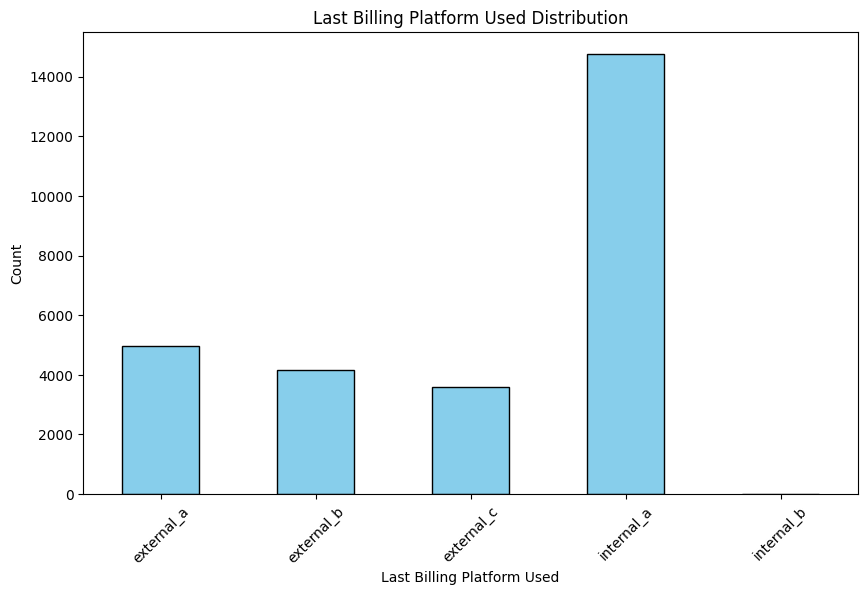

In [23]:
# Count occurrences for each last_billing_platform_used
last_billing_platform_used = data_df['last_billing_platform_used'].value_counts().sort_index()

last_billing_platform_used.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Last Billing Platform Used Distribution')
plt.xlabel('Last Billing Platform Used')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Frequency Distribution
last_billing_platform_used_percentage = data_df['last_billing_platform_used'].value_counts(normalize=True) * 100

# Mode
last_billing_platform_used_mode = data_df['last_billing_platform_used'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['last_billing_platform_used'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['last_billing_platform_used'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(last_billing_platform_used)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(last_billing_platform_used_percentage)
print("\nMode of Category:", last_billing_platform_used_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
last_billing_platform_used
external_a     4962
external_b     4171
external_c     3594
internal_a    14760
internal_b        7
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
last_billing_platform_used
internal_a   53.68
external_a   18.05
external_b   15.17
external_c   13.07
internal_b    0.03
Name: proportion, dtype: float64

Mode of Category: internal_a

Cross-Tabulation:
user_state                  Active  Churned
last_billing_platform_used                 
external_a                    2672     2290
external_b                    2007     2164
external_c                    1881     1713
internal_a                    7339     7421
internal_b                       5        2

Chi-Square Test p-value: 2.2947587328938732e-08


___Last Subscription Status___

__Observations__
1. __Percentage Distribution__:

   "Deactivated" accounts for the highest proportion at 48.86%, indicating that nearly half of the data falls under this category. "Regular" follows closely with 44.23% of the data.

2. __Mode__:

   The mode (most frequent category) is "deactivated," suggesting that this category is the central tendency of the data in terms of subscription status.

3. __Cross-Tabulation__:

   The cross-tabulation shows the distribution of "last_subscription_status" categories across "Active" and "Churned" user states. "Deactivated" is prevalent in both active and churned states, indicating its significance in understanding user behavior.

4. __Chi-Square Test__:

   The p-value of the chi-square test (0.0) is extremely low, suggesting a significant association between "last_subscription_status" and user states ("Active" and "Churned")

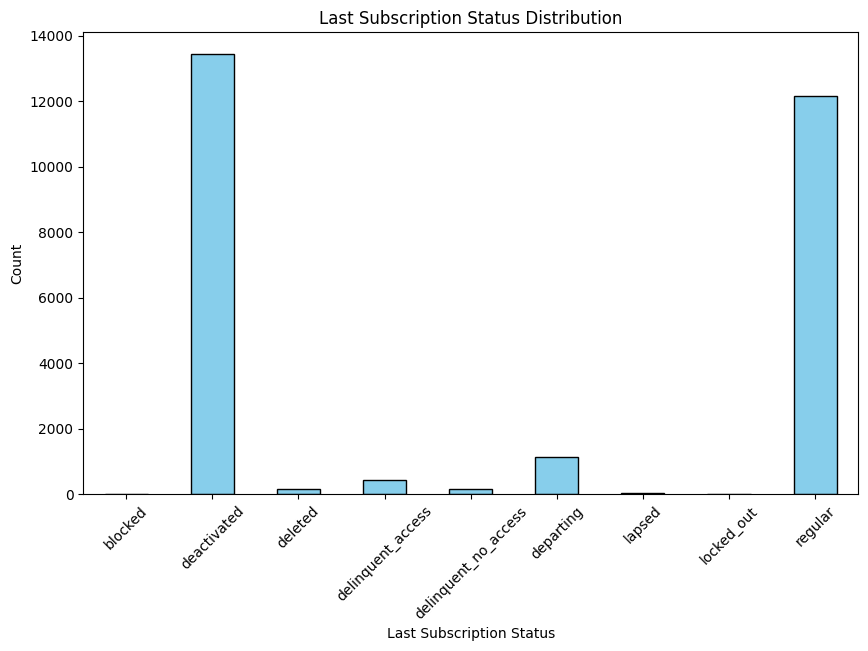

In [25]:
# Count occurrences for each last_subscription_status
last_subscription_status = data_df['last_subscription_status'].value_counts().sort_index()

last_subscription_status.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Last Subscription Status Distribution')
plt.xlabel('Last Subscription Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Frequency Distribution
last_subscription_status_percentage = data_df['last_subscription_status'].value_counts(normalize=True) * 100

# Mode
last_subscription_status_mode = data_df['last_subscription_status'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['last_subscription_status'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['last_subscription_status'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(last_subscription_status)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(last_subscription_status_percentage)
print("\nMode of Category:", last_subscription_status_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
last_subscription_status
blocked                     1
deactivated             13433
deleted                   152
delinquent_access         436
delinquent_no_access      144
departing                1145
lapsed                     21
locked_out                  2
regular                 12160
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
last_subscription_status
deactivated            48.86
regular                44.23
departing               4.16
delinquent_access       1.59
deleted                 0.55
delinquent_no_access    0.52
lapsed                  0.08
locked_out              0.01
blocked                 0.00
Name: proportion, dtype: float64

Mode of Category: deactivated

Cross-Tabulation:
user_state                Active  Churned
last_subscription_status                 
blocked                        1        0
deactivated                   15    13418
deleted                       25      127
delinquent_access            43

___Created At___

The "created_at" timestamp denotes the account creation time. 
To deepen our understanding, I analyzed this feature at various levels of granularity. 
Specifically, I engineered three new columns focusing on accounts created each month, each quarter, and each year. 
This approach allows for a more detailed exploration of account creation patterns over different timeframes.

__Observations for the year of account creation__
1. __Percentage Distribution__:

   * In terms of percentage distribution, the year 2023 stands out significantly, constituting 64.26% of all account creations in the dataset.
   * The year 2022 accounts for 29.91% of account creations, indicating a substantial portion but notably less than 2023.

2. __Mode__:

   The mode, indicating the most frequent year of account creation, is 2023, aligning with the highest frequency and percentage distribution.

3. __Cross-Tabulation__:

   * Breaking down the data by user state (Active vs. Churned), we observe a consistent pattern across the years.
   * In each year, the number of active accounts generally exceeds churned accounts, showcasing a positive trend in account retention over time.
   * However, it's noteworthy that the magnitude of active and churned accounts varies significantly between years, with 2023 having the largest gap between active and churned accounts.

4. __Chi-Square Test__:

   * The Chi-Square Test p-value of 2.031674734600594e-35 indicates a statistically significant relationship between the "created_at_year" and user state (Active vs. Churned).
   * This suggests that the year of account creation does have an impact on the likelihood of an account being active or churned.

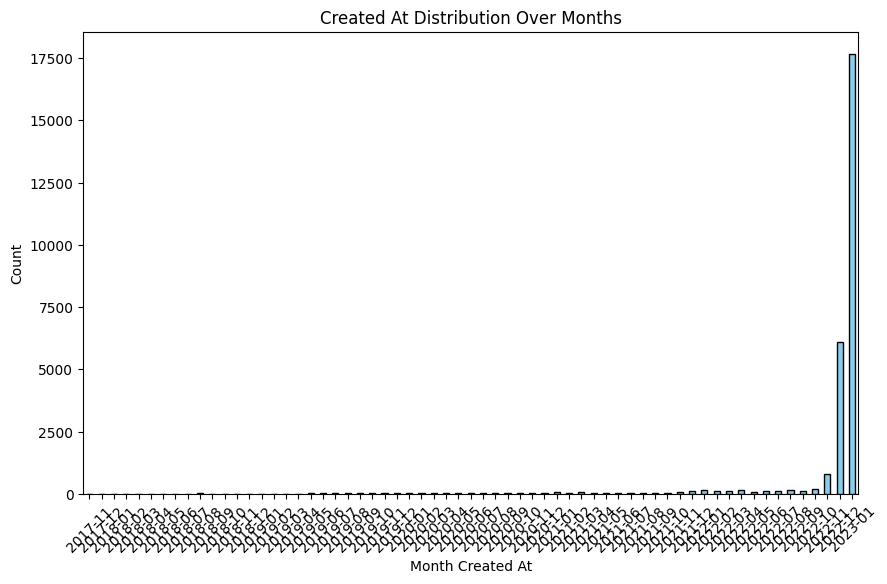

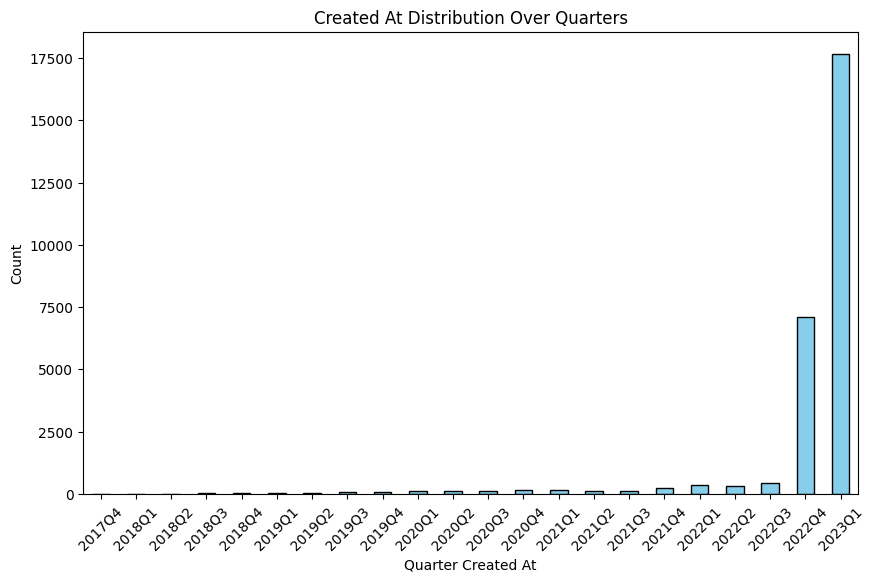

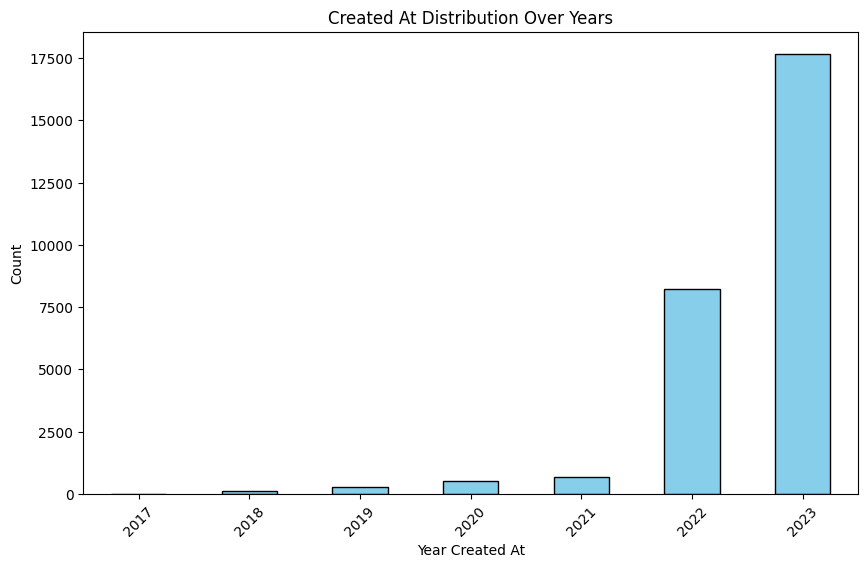

In [27]:
# Extract year and month of the created_at column
data_df['created_at_year_month'] = data_df['created_at'].dt.to_period('M')

# Count occurrences for each year-month 
month_counts = data_df['created_at_year_month'].value_counts().sort_index()

month_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Created At Distribution Over Months')
plt.xlabel('Month Created At')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Extract year and quarter of the created_at column
data_df['created_at_year_quarter'] = data_df['created_at'].dt.to_period('Q')

# Count occurrences for each year-quarter
quarter_counts = data_df['created_at_year_quarter'].value_counts().sort_index()

quarter_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Created At Distribution Over Quarters')
plt.xlabel('Quarter Created At')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Extract year of the created_at column
data_df['created_at_year'] = data_df['created_at'].dt.to_period('Y')

# Count occurrences for each year
year_counts = data_df['created_at_year'].value_counts().sort_index()

year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Created At Distribution Over Years')
plt.xlabel('Year Created At')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Frequency Distribution
created_at_year_percentage = data_df['created_at_year'].value_counts(normalize=True) * 100

# Mode
created_at_year_mode = data_df['created_at_year'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['created_at_year'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['created_at_year'].isnull().sum()


# Display or print the extracted information
print("Frequency Distribution:")
print(year_counts)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(created_at_year_percentage)
print("\nMode of Category:", created_at_year_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
created_at_year
2017        6
2018      115
2019      285
2020      528
2021      670
2022     8223
2023    17667
Freq: Y-DEC, Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
created_at_year
2023   64.26
2022   29.91
2021    2.44
2020    1.92
2019    1.04
2018    0.42
2017    0.02
Freq: Y-DEC, Name: proportion, dtype: float64

Mode of Category: 2023

Cross-Tabulation:
user_state       Active  Churned
created_at_year                 
2017                  2        4
2018                 55       60
2019                139      146
2020                262      266
2021                358      312
2022               3665     4558
2023               9423     8244

Chi-Square Test p-value: 2.031674734600594e-35


___Has Email___

__Observations__
1. __Percentage Distribution__:

   64.66% of the accounts in the dataset have an email address linked, while 35.34% do not. This indicates that a majority of the users prefer to provide their email addresses.

2. __Mode__:

   The mode for the "has_email" attribute is True, suggesting that having an email associated is the more common scenario among the accounts.

3. __Cross-Tabulation__:
   * When comparing the state of accounts (Active vs. Churned) with the presence of an email address:
       * 9,045 of the users with an email are active, while 8,732 are churned.
       * For users without an email, the numbers are almost even, with 4,859 active and 4,858 churned.
   * This data reveals a slightly higher retention for users who have provided their email, although the distribution is fairly balanced.

4. __Chi-Square Test__:
   * The Chi-Square Test p-value of 0.1691561048914028 indicates that there is no statistically significant association between having an email and the user state (Active vs. Churned).
   * This suggests that whether or not an account has an email associated does not significantly impact whether the account will be active or churned.

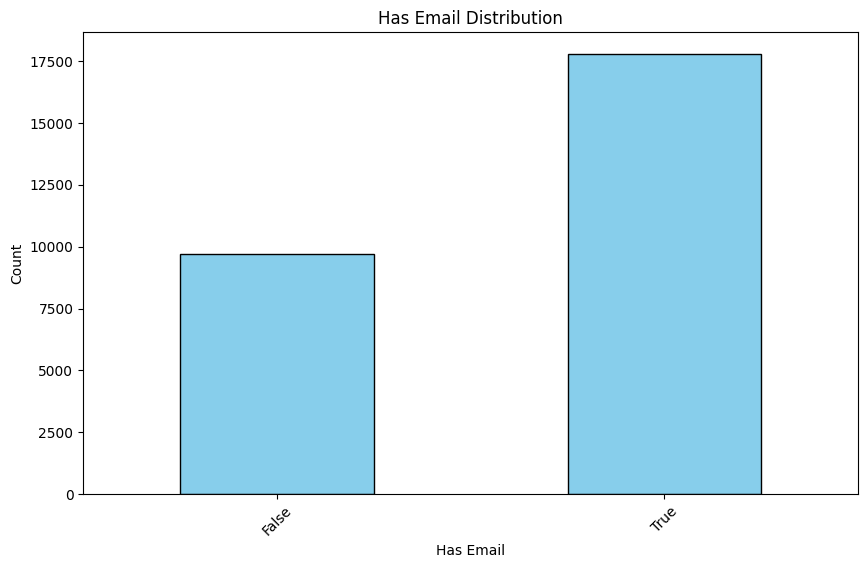

In [29]:
# Count occurrences for has_email
has_email = data_df['has_email'].value_counts().sort_index()

has_email.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Has Email Distribution')
plt.xlabel('Has Email')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Frequency Distribution
has_email_percentage = data_df['has_email'].value_counts(normalize=True) * 100

# Mode
has_email_mode = data_df['has_email'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['has_email'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['created_at_year'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(has_email)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(has_email_percentage)
print("\nMode of Category:", has_email_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
has_email
False     9717
True     17777
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
has_email
True    64.66
False   35.34
Name: proportion, dtype: float64

Mode of Category: True

Cross-Tabulation:
user_state  Active  Churned
has_email                  
False         4859     4858
True          9045     8732

Chi-Square Test p-value: 0.1691561048914028


___Has Phone___

1. __Percentage Distribution__:

   54.55% of the accounts in the dataset have a phone number linked, while 45.45% do not. This indicates that more than half of the users prefer to provide their phone numbers.

2. __Mode__:

   The mode for the "has_phone" attribute is True, suggesting that having a phone number is the more common scenario among the accounts.
   
3. __Cross-Tabulation__:
   * When comparing the state of accounts (Active vs. Churned) with the presence of a phone number:
       * 7,867 of the users with a phone are active, while 7,130 are churned.
       * For users without a phone, the numbers are 6,037 active and 6,460 churned.
   * This distribution reveals that users with a phone number have a slightly higher retention rate than those without.

4. __Chi-Square Test__:
   * The Chi-Square Test p-value of 7.899774808036603e-12 indicates that there is a statistically significant association between having a phone number and the user state (Active vs. Churned).
   * This suggests that the presence of a phone number may influence the likelihood of an account remaining active, potentially due to increased engagement or security features associated with phone verification.

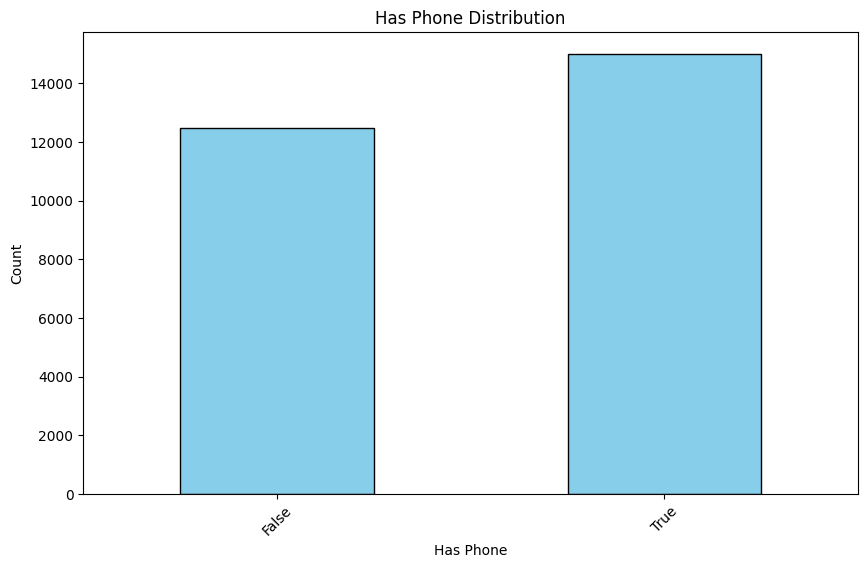

In [31]:
# Count occurrences for has_phone
has_phone = data_df['has_phone'].value_counts().sort_index()

has_phone.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Has Phone Distribution')
plt.xlabel('Has Phone')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [32]:
# Frequency Distribution
has_phone_percentage = data_df['has_phone'].value_counts(normalize=True) * 100

# Mode
has_phone_mode = data_df['has_phone'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['has_phone'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['has_phone'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(has_phone)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(has_phone_percentage)
print("\nMode of Category:", has_phone_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
has_phone
False    12497
True     14997
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
has_phone
True    54.55
False   45.45
Name: proportion, dtype: float64

Mode of Category: True

Cross-Tabulation:
user_state  Active  Churned
has_phone                  
False         6037     6460
True          7867     7130

Chi-Square Test p-value: 7.899774808036603e-12


___User State___

__Observations__
1. __Percentage Distribution__:

   50.57% of the accounts in the dataset are active, suggesting a slightly higher proportion compared to the 49.43% that have churned. This shows a near-even split in the dataset between active and churned users.

2. __Mode__:

   The mode for the "user_state" attribute is Active, indicating that there are slightly more active accounts than churned ones within the dataset.

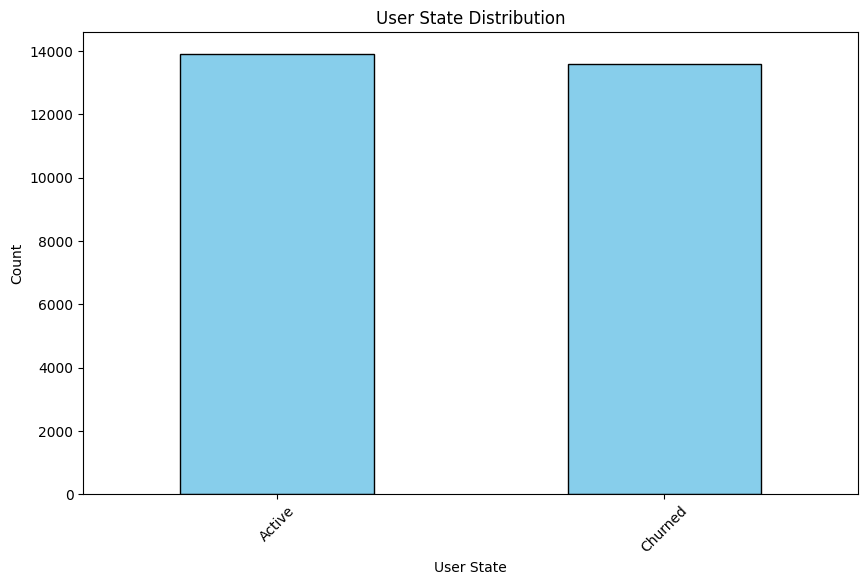

In [33]:
# Count occurrences for user_state
user_state = data_df['user_state'].value_counts().sort_index()

user_state.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('User State Distribution')
plt.xlabel('User State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Frequency Distribution
user_state_percentage = data_df['user_state'].value_counts(normalize=True) * 100

# Mode
user_state_mode = data_df['user_state'].mode()[0]

missing_values = data_df['user_state'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(user_state)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(user_state_percentage)
print("\nMode of Category:", user_state_mode)

Frequency Distribution:
user_state
Active     13904
Churned    13590
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
user_state
Active    50.57
Churned   49.43
Name: proportion, dtype: float64

Mode of Category: Active


___Total Payments___

__Observations__
1. __Percentage Distribution__:

   32.51% of accounts have made only one payment, which is the most common. The frequency of accounts making payments decreases as the number of payments increases, with only 0.09% making five payments, and even fewer for six to eight payments.

2. __Mode__:

   The mode for the "total_payments" attribute is 1.0, showing that a single payment is the most common among the accounts.
   
3. __Cross-Tabulation__:
   * There is a significant drop in churn as the number of payments increases:
       * Only 133 of the users who made a single payment are active, while 8,805 have churned.
       * The number of active users increases dramatically for three and four payments, suggesting better retention with more engagement (payments).
       * Accounts with five to eight payments are all active, indicating a trend where higher payment counts correlate with better retention.

4. __Chi-Square Test__:
   * The Chi-Square Test p-value is effectively 0, indicating a highly statistically significant association between the number of payments made and the user state (Active vs. Churned).
   * This suggests that as the number of payments increases, the likelihood of remaining active also increases dramatically.

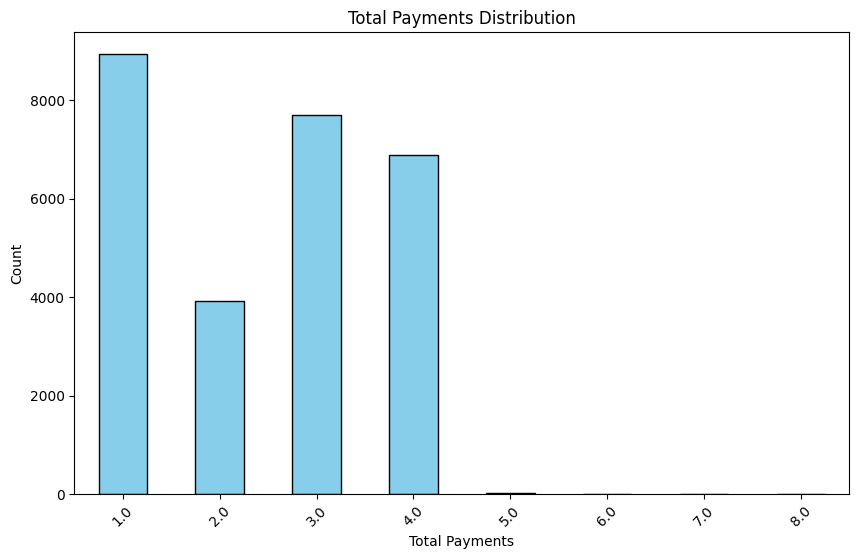

In [35]:
# Count occurrences for total_payments
total_payments = data_df['total_payments'].value_counts().sort_index()

total_payments.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Payments Distribution')
plt.xlabel('Total Payments')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Frequency Distribution
total_payments_percentage = data_df['total_payments'].value_counts(normalize=True) * 100

# Mode
total_payments_mode = data_df['total_payments'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['total_payments'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['total_payments'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(total_payments)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(total_payments_percentage)
print("\nMode of Category:", total_payments_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
total_payments
1.00    8938
2.00    3922
3.00    7704
4.00    6889
5.00      24
6.00       6
7.00       3
8.00       8
Name: count, dtype: int64

Missing Values:
0

Percentage Distribution:
total_payments
1.00   32.51
3.00   28.02
4.00   25.06
2.00   14.26
5.00    0.09
8.00    0.03
6.00    0.02
7.00    0.01
Name: proportion, dtype: float64

Mode of Category: 1.0

Cross-Tabulation:
user_state      Active  Churned
total_payments                 
1.00               133     8805
2.00               435     3487
3.00              6423     1281
4.00              6872       17
5.00                24        0
6.00                 6        0
7.00                 3        0
8.00                 8        0

Chi-Square Test p-value: 0.0


___Total Paid___

__Observations__

The ANOVA test results revealed a highly significant difference in total paid between active and churned users.

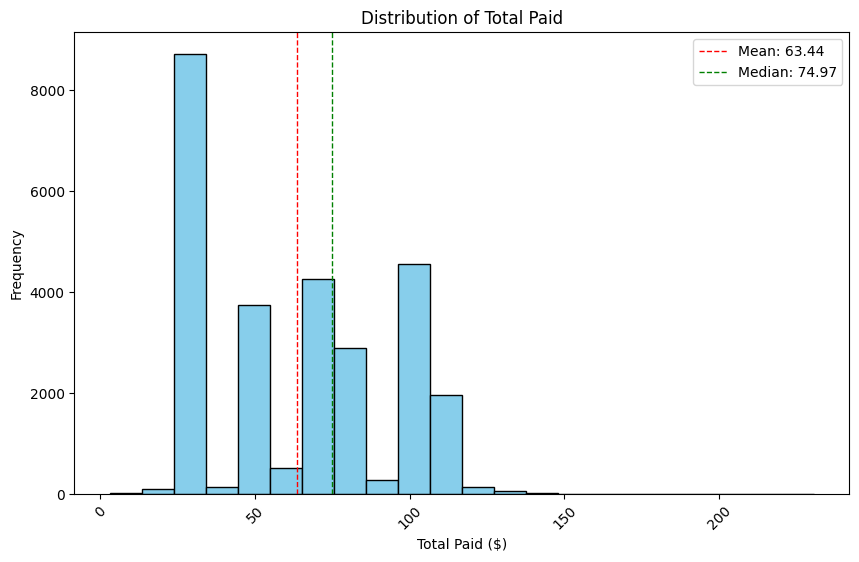

count   27,494.00
mean        63.44
std         31.28
min          3.00
25%         26.75
50%         74.97
75%         92.98
max        220.69
Name: total_paid, dtype: float64

In [37]:
# Determine the range of total_paid values
min_value = min(data_df['total_paid'])
max_value = max(data_df['total_paid'])

# Calculate the number of bins based on $10 increments
num_bins = int((max_value - min_value) / 10) + 1

plt.hist(data_df['total_paid'], bins=num_bins, range=(min_value, max_value + 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Total Paid')
plt.xlabel('Total Paid ($)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Calculate mean and median
mean_val = np.mean(data_df['total_paid'])
median_val = np.median(data_df['total_paid'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['total_paid'].describe()

In [38]:
from scipy.stats import f_oneway

# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['total_paid']
churned_data = data_df[data_df['user_state'] == 'Churned']['total_paid']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in total paid between user states is statistically significant.")
else:
    print("There is no statistically significant difference in total paid between user states.")

ANOVA Test Results:
F-Statistic: 54516.96942596897
P-Value: 0.0
The difference in total paid between user states is statistically significant.


___First Payment At___

The dataset pertains to new subscribers in January, presenting an opportunity to delve into user behavior and payment patterns during subsequent months. 
A pertinent feature was engineered to categorize users based on whether they subscribed in the first or second half of January. 
This segmentation aids in understanding payment continuity, particularly focusing on April payments.

__Payment Analysis__:
Users who subscribed in the first half of January are expected to have made payments in April if they remain active. 
Conversely, subscribers from the second half of January may not have completed their April payment cycle.

__Observations__

1. __Percentage Distribution__:

   The percentage distribution shows that 50.73% of accounts made their first payment in the second half of the month, while 49.27% made their first payment in the first half.

2. __Mode__:

   The mode for the "first_payment_half_month" attribute is the Second Half, indicating that a slightly higher number of accounts made their first payment in the second half of the month.
   
3. __Cross-Tabulation__:
   * Analyzing the user state (Active vs. Churned) based on the first payment half-month, we find the following:
       * For accounts that made their first payment in the First Half, there are 6,226 Active users and 7,007 Churned users.
       * For accounts that made their first payment in the Second Half, there are 7,339 Active users and 6,285 Churned users.
       * This suggests a slightly higher retention rate for accounts that made their first payment in the Second Half of the month.

4. __Chi-Square Test__:
   
   The Chi-Square Test p-value of 6.225281510117913e-29 indicates a highly statistically significant association between the first payment half-month and the user state (Active vs. Churned). This means that the timing of the first payment in the month is correlated with the likelihood of the account being Active or Churned.

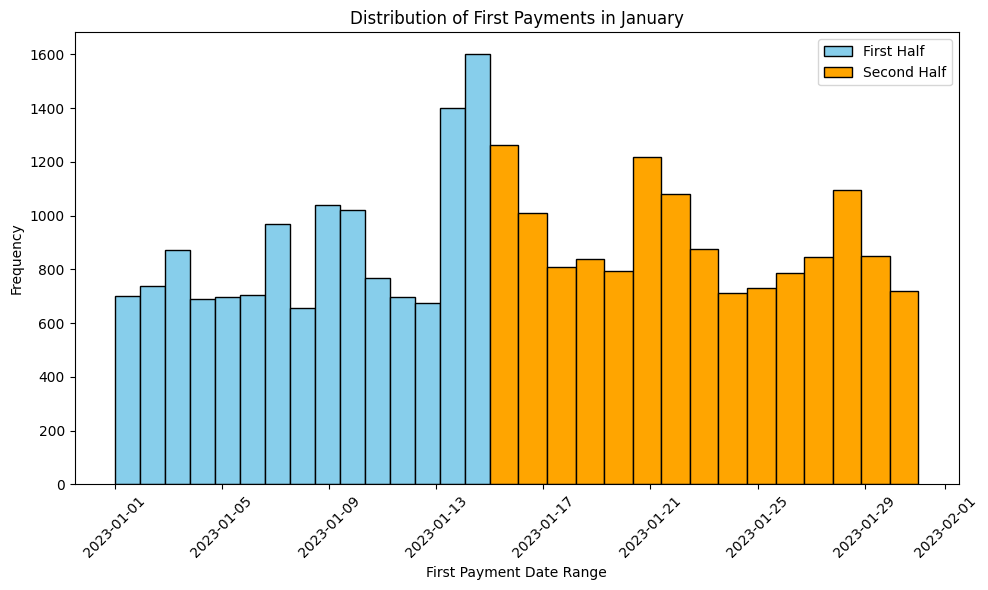

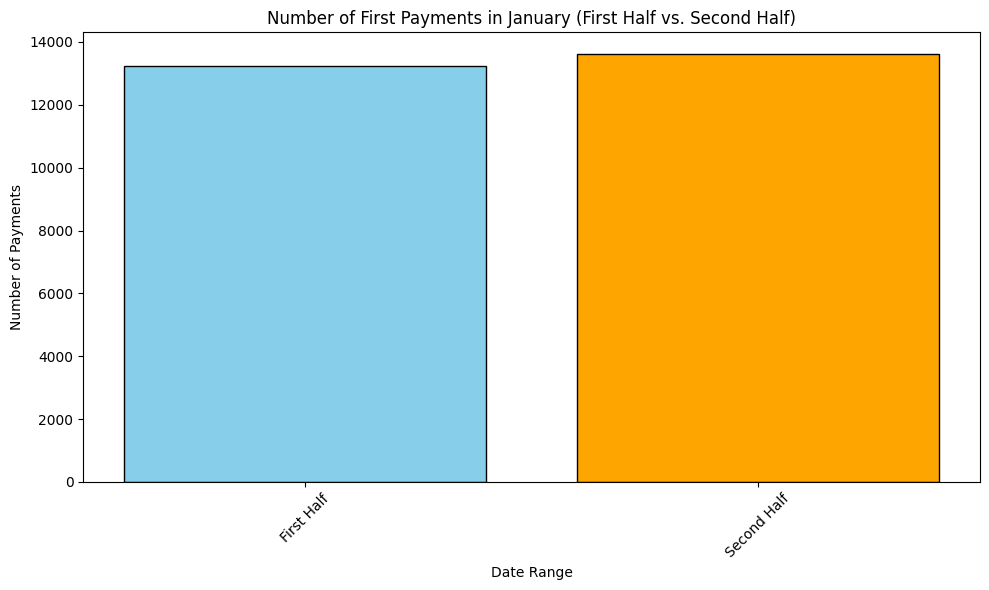

In [39]:
# Define the range of dates for the first and second halves of January
start_date = pd.to_datetime('2023-01-01')
mid_date = pd.to_datetime('2023-01-15')
end_date = pd.to_datetime('2023-01-31')

# Categorize dates into first and second halves of January
first_half = data_df['first_payment_at'][(data_df['first_payment_at'] >= start_date) & (data_df['first_payment_at'] <= mid_date)]
second_half = data_df['first_payment_at'][(data_df['first_payment_at'] > mid_date) & (data_df['first_payment_at'] <= end_date)]

plt.hist(first_half, bins=15, color='skyblue', edgecolor='black', label='First Half')
plt.hist(second_half, bins=15, color='orange', edgecolor='black', label='Second Half')
plt.xlabel('First Payment Date Range')
plt.ylabel('Frequency')
plt.title('Distribution of First Payments in January')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Count the number of payments in each half
first_half_count = len(first_half)
second_half_count = len(second_half)

plt.bar(['First Half', 'Second Half'], [first_half_count, second_half_count], color=['skyblue', 'orange'], edgecolor='black')
plt.xlabel('Date Range')
plt.ylabel('Number of Payments')
plt.title('Number of First Payments in January (First Half vs. Second Half)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Create a new column based on the categorization
data_df['first_payment_half_month'] = pd.cut(data_df['first_payment_at'], bins=[start_date, mid_date, end_date],
                                             labels=['First Half', 'Second Half'], right=False)
# Count occurrences for irst_payment_half_month
first_payment_half_month = data_df['first_payment_half_month'].value_counts().sort_index()

# Frequency Distribution
first_payment_half_month_percentage = data_df['first_payment_half_month'].value_counts(normalize=True) * 100

# Mode
first_payment_half_month_mode = data_df['first_payment_half_month'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['first_payment_half_month'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['first_payment_half_month'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(first_payment_half_month)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(first_payment_half_month_percentage)
print("\nMode of Category:", first_payment_half_month_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
first_payment_half_month
First Half     13233
Second Half    13624
Name: count, dtype: int64

Missing Values:
637

Percentage Distribution:
first_payment_half_month
Second Half   50.73
First Half    49.27
Name: proportion, dtype: float64

Mode of Category: Second Half

Cross-Tabulation:
user_state                Active  Churned
first_payment_half_month                 
First Half                  6226     7007
Second Half                 7339     6285

Chi-Square Test p-value: 6.225281510117913e-29


___Trial Length___

A new feature is created from the trial_started_at and trial_ended_at information, indicating the trial length.

__Observations__

1. __Percentage Distribution__:

   The percentage distribution shows that 99.45% of accounts have a trial length of 7 days.
   Other trial lengths constitute a very small percentage of the dataset.

2. __Mode__:

   The mode for the "trial_length_days" attribute is 7.0, indicating that a trial length of 7 days is the most common among the accounts.
   
3. __Cross-Tabulation__:
   * Analyzing the user state (Active vs. Churned) based on trial length, we find the following:
       * For accounts with a trial length of 7 days, there are 13,774 Active users and 13,367 Churned users.
       * There are very few accounts with trial lengths other than 7 days, and their distribution between Active and Churned users is generally balanced.

4. __Chi-Square Test__:
   
   The Chi-Square Test p-value of 0.11062852394924244 indicates that there is no statistically significant association between trial length and the user state (Active vs. Churned). This suggests that trial length alone may not be a strong predictor of whether an account will be Active or Churned.

In [41]:
# Calculate the trial length
data_df['trial_length_days'] = (data_df['trial_ended_at'] - data_df['trial_started_at']).dt.days

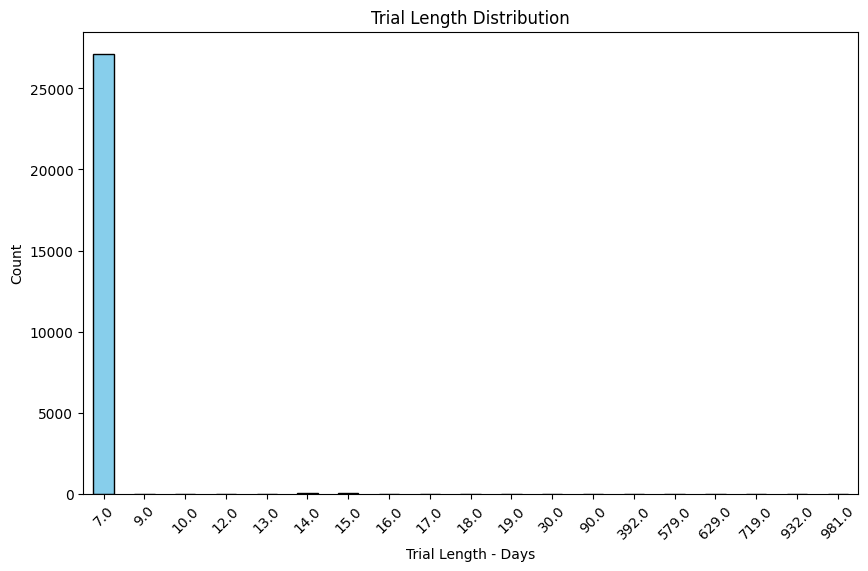

In [42]:
# Count occurrences for total_payments
trial_length_days = data_df['trial_length_days'].value_counts().sort_index()

trial_length_days.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Trial Length Distribution')
plt.xlabel('Trial Length - Days')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [43]:
# Frequency Distribution
trial_length_days_percentage = data_df['trial_length_days'].value_counts(normalize=True) * 100

# Mode
trial_length_days_mode = data_df['trial_length_days'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['trial_length_days'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['trial_length_days'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(trial_length_days)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(trial_length_days_percentage)
print("\nMode of Category:", trial_length_days_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
trial_length_days
7.00      27141
9.00          1
10.00         1
12.00         2
13.00         1
14.00        74
15.00        26
16.00         8
17.00        11
18.00         6
19.00         4
30.00         9
90.00         1
392.00        1
579.00        1
629.00        1
719.00        1
932.00        1
981.00        1
Name: count, dtype: int64

Missing Values:
203

Percentage Distribution:
trial_length_days
7.00     99.45
14.00     0.27
15.00     0.10
17.00     0.04
30.00     0.03
16.00     0.03
18.00     0.02
19.00     0.01
12.00     0.01
579.00    0.00
392.00    0.00
90.00     0.00
719.00    0.00
10.00     0.00
13.00     0.00
932.00    0.00
9.00      0.00
629.00    0.00
981.00    0.00
Name: proportion, dtype: float64

Mode of Category: 7.0

Cross-Tabulation:
user_state         Active  Churned
trial_length_days                 
7.00                13774    13367
9.00                    1        0
10.00                   0        1
12.00                   0   

___Acquisition Biller___

__Observations__

1. __Percentage Distribution__:

   "Internal_a" is the most prevalent acquisition biller, accounting for 53.82% of the dataset.
   This is followed by "external_a," "external_b," "external_c," and "internal_b" in descending order.

2. __Mode__:

   The mode for the "acquisition_biller" attribute is "internal_a," indicating that this is the most common acquisition biller category.
   
3. __Cross-Tabulation__:
   * When comparing the user state (Active vs. Churned) based on acquisition biller, we observe the following:
       * "Internal_a" has a relatively balanced distribution between Active (7,344) and Churned (7,369) users.
       * The external acquisition billers ("external_a," "external_b," "external_c") show variations in the distribution between Active and Churned users.
       * "Internal_b" has the lowest count among all categories, with a relatively balanced distribution between Active (238) and Churned (245) users.

4. __Chi-Square Test__:
   
   The Chi-Square Test p-value of 7.775331878871996e-12 indicates a highly statistically significant association between acquisition biller and the user state (Active vs. Churned). This suggests that the choice of acquisition biller may have a significant impact on whether an account remains Active or becomes Churned.

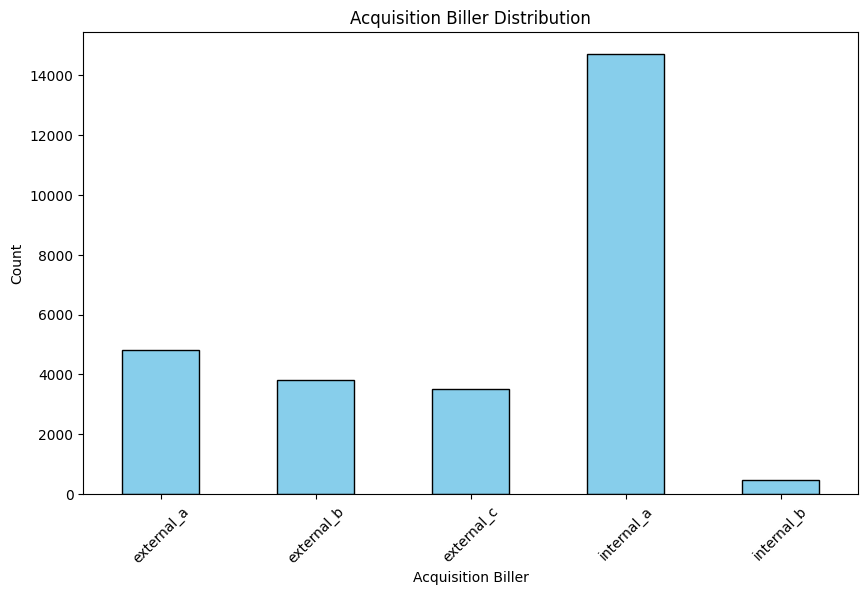

In [44]:
# Count occurrences for acquisition_biller
acquisition_biller = data_df['acquisition_biller'].value_counts().sort_index()

acquisition_biller.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Acquisition Biller Distribution')
plt.xlabel('Acquisition Biller')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Frequency Distribution
acquisition_biller_percentage = data_df['acquisition_biller'].value_counts(normalize=True) * 100

# Mode
acquisition_biller_mode = data_df['acquisition_biller'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['acquisition_biller'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['acquisition_biller'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(acquisition_biller)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(acquisition_biller_percentage)
print("\nMode of Category:", acquisition_biller_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
acquisition_biller
external_a     4824
external_b     3808
external_c     3511
internal_a    14713
internal_b      483
Name: count, dtype: int64

Missing Values:
155

Percentage Distribution:
acquisition_biller
internal_a   53.82
external_a   17.65
external_b   13.93
external_c   12.84
internal_b    1.77
Name: proportion, dtype: float64

Mode of Category: internal_a

Cross-Tabulation:
user_state          Active  Churned
acquisition_biller                 
external_a            2619     2205
external_b            1783     2025
external_c            1854     1657
internal_a            7344     7369
internal_b             238      245

Chi-Square Test p-value: 7.775331878871996e-12


___SignUp Platform___

__Observations__

1. __Percentage Distribution__:

   "Mobile_web_b" is the most prevalent signup platform, constituting 26.57% of the dataset. This is followed by "tv_platform_c," "tv_platform_e," "mobile_b," and "web" in descending order.

2. __Mode__:

   The mode for the "signup_platform" attribute is "mobile_web_b," indicating that this is the most common signup platform category.
   
3. __Cross-Tabulation__:
   * When comparing the user state (Active vs. Churned) based on signup platform, we observe the following:
       * "Mobile_web_b" has a relatively balanced distribution between Active (3,554) and Churned (3,748) users.
       * The TV platforms ("tv_platform_a" through "tv_platform_g") show variations in the distribution between Active and Churned users.
       * "Mobile_b" and "mobile_web_a" also show a relatively balanced distribution between Active and Churned users.
       * "Mobile_a" has the lowest count among all categories, with a slightly higher number of Active users than Churned users.

4. __Chi-Square Test__:
   
   The Chi-Square Test p-value of 6.197223645048541e-14 indicates a highly statistically significant association between the signup platform and the user state (Active vs. Churned). This suggests that the choice of signup platform may have a significant impact on whether an account remains Active or becomes Churned.

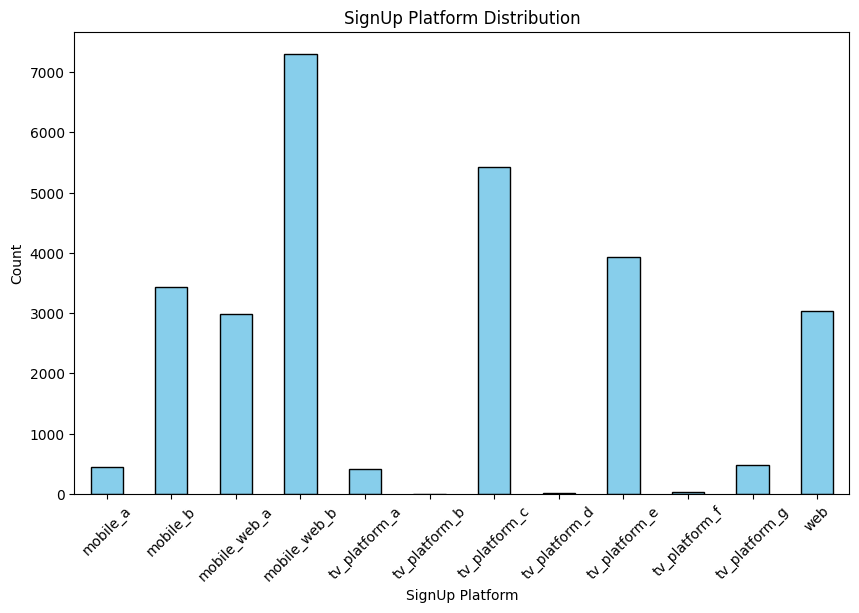

In [46]:
# Count occurrences for signup_platform
signup_platform = data_df['signup_platform'].value_counts().sort_index()

signup_platform.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('SignUp Platform Distribution')
plt.xlabel('SignUp Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [47]:
# Frequency Distribution
signup_platform_percentage = data_df['signup_platform'].value_counts(normalize=True) * 100

# Mode
signup_platform_mode = data_df['signup_platform'].mode()[0]

# Cross-Tabulation (with user_state)
cross_tab = pd.crosstab(data_df['signup_platform'], data_df['user_state'])

# Chi-Square Test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected = chi2_contingency(cross_tab)

missing_values = data_df['signup_platform'].isnull().sum()

# Display or print the extracted information
print("Frequency Distribution:")
print(signup_platform)
print("\nMissing Values:")
print(missing_values)
print("\nPercentage Distribution:")
print(signup_platform_percentage)
print("\nMode of Category:", signup_platform_mode)
print("\nCross-Tabulation:")
print(cross_tab)
print("\nChi-Square Test p-value:", p_val)

Frequency Distribution:
signup_platform
mobile_a          446
mobile_b         3430
mobile_web_a     2981
mobile_web_b     7302
tv_platform_a     411
tv_platform_b       3
tv_platform_c    5418
tv_platform_d      18
tv_platform_e    3934
tv_platform_f      37
tv_platform_g     480
web              3027
Name: count, dtype: int64

Missing Values:
7

Percentage Distribution:
signup_platform
mobile_web_b    26.57
tv_platform_c   19.71
tv_platform_e   14.31
mobile_b        12.48
web             11.01
mobile_web_a    10.85
tv_platform_g    1.75
mobile_a         1.62
tv_platform_a    1.50
tv_platform_f    0.13
tv_platform_d    0.07
tv_platform_b    0.01
Name: proportion, dtype: float64

Mode of Category: mobile_web_b

Cross-Tabulation:
user_state       Active  Churned
signup_platform                 
mobile_a            252      194
mobile_b           1624     1806
mobile_web_a       1399     1582
mobile_web_b       3554     3748
tv_platform_a       231      180
tv_platform_b         2       

___Distinct Channels___

__Observations__

The ANOVA test suggests that the number of distinct channels has a significant impact on whether an account remains active or becomes churned.

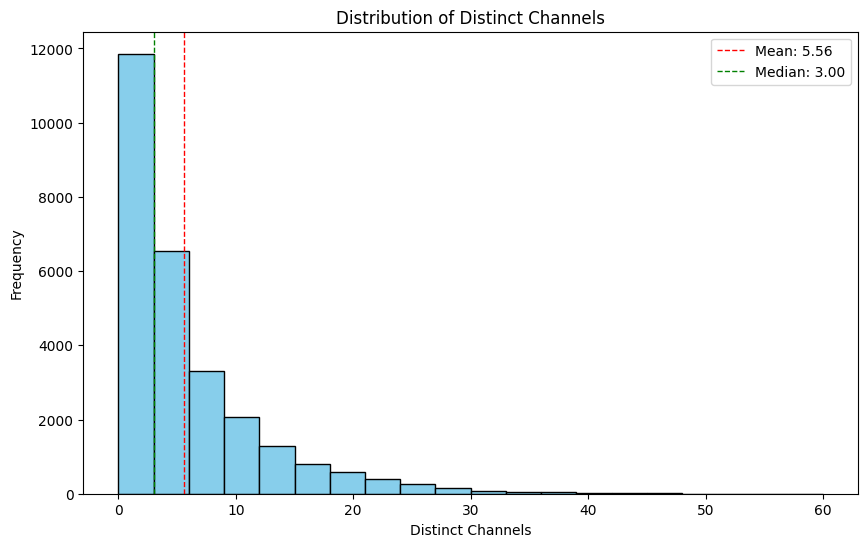

count   27,494.00
mean         5.56
std          6.18
min          0.00
25%          1.00
50%          3.00
75%          7.00
max         60.00
Name: distinct_channels, dtype: float64

In [48]:
plt.hist(data_df['distinct_channels'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distinct Channels')
plt.ylabel('Frequency')
plt.title('Distribution of Distinct Channels')

# Calculate mean and median
mean_val = np.mean(data_df['distinct_channels'])
median_val = np.median(data_df['distinct_channels'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['distinct_channels'].describe()

In [49]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['distinct_channels']
churned_data = data_df[data_df['user_state'] == 'Churned']['distinct_channels']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in distinct channels between user states is statistically significant.")
else:
    print("There is no statistically significant difference in distinct channels between user states.")

ANOVA Test Results:
F-Statistic: 399.5778678933139
P-Value: 2.887121700337668e-88
The difference in distinct channels between user states is statistically significant.


___Distinct Shows___

__Observations__

The ANOVA test implies that the number of distinct shows watched has a significant impact on whether an account remains active or becomes churned.

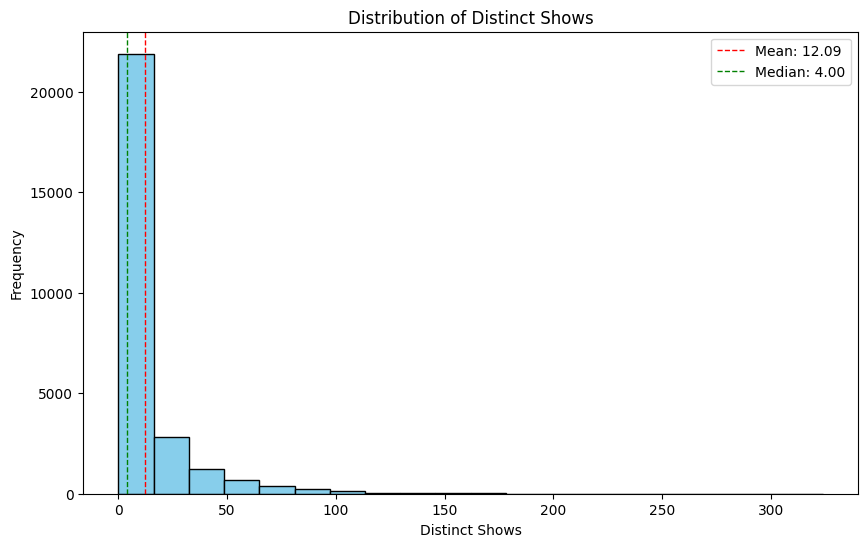

count   27,494.00
mean        12.09
std         19.79
min          0.00
25%          2.00
50%          4.00
75%         13.00
max        324.00
Name: distinct_shows, dtype: float64

In [50]:
plt.hist(data_df['distinct_shows'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distinct Shows')
plt.ylabel('Frequency')
plt.title('Distribution of Distinct Shows')
# Calculate mean and median
mean_val = np.mean(data_df['distinct_shows'])
median_val = np.median(data_df['distinct_shows'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['distinct_shows'].describe()

In [51]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['distinct_shows']
churned_data = data_df[data_df['user_state'] == 'Churned']['distinct_shows']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in distinct shows between user states is statistically significant.")
else:
    print("There is no statistically significant difference in distinct shows between user states.")

ANOVA Test Results:
F-Statistic: 329.8873070862012
P-Value: 2.730824738007805e-73
The difference in distinct shows between user states is statistically significant.


___Hours Watched___

__Observations__

The ANOVA test suggests that the amount of time spent watching content has a substantial impact on whether users remain active or become churned.

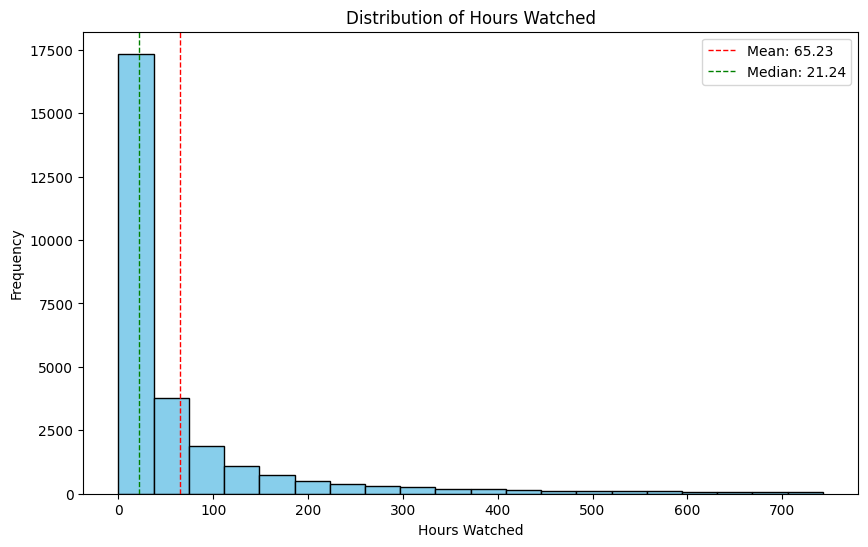

count   27,494.00
mean        65.23
std        111.92
min          0.00
25%          7.90
50%         21.24
75%         67.35
max        742.97
Name: hours_watched, dtype: float64

In [52]:
plt.hist(data_df['hours_watched'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Hours Watched')
plt.ylabel('Frequency')
plt.title('Distribution of Hours Watched')
# Calculate mean and median
mean_val = np.mean(data_df['hours_watched'])
median_val = np.median(data_df['hours_watched'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['hours_watched'].describe()

In [53]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['hours_watched']
churned_data = data_df[data_df['user_state'] == 'Churned']['hours_watched']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in hours watched between user states is statistically significant.")
else:
    print("There is no statistically significant difference in hours watched between user states.")

ANOVA Test Results:
F-Statistic: 997.0399100142749
P-Value: 5.482002973146842e-215
The difference in hours watched between user states is statistically significant.


___Shows Saved___

__Observations__

The ANOVA test indicates that the behavior of saving shows varies significantly between active and churned users.

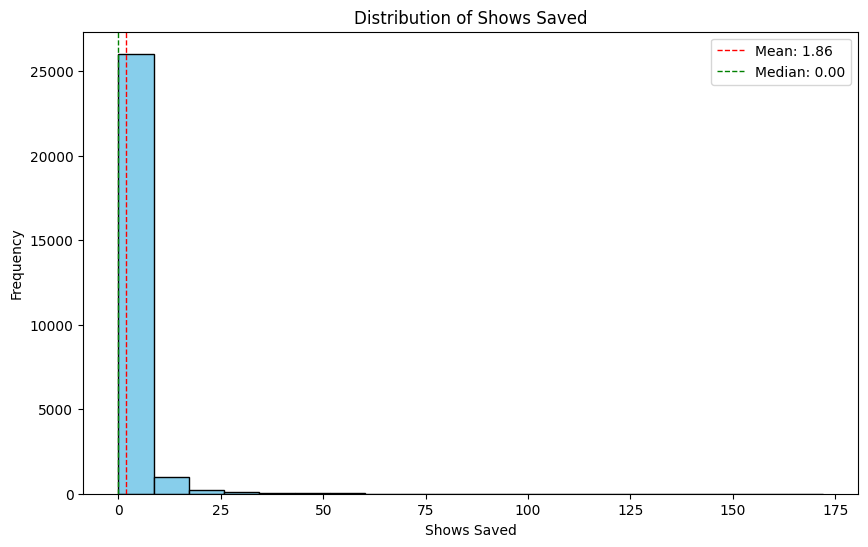

count   27,494.00
mean         1.86
std          5.03
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        172.00
Name: shows_saved, dtype: float64

In [54]:
plt.hist(data_df['shows_saved'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Shows Saved')
plt.ylabel('Frequency')
plt.title('Distribution of Shows Saved')
# Calculate mean and median
mean_val = np.mean(data_df['shows_saved'])
median_val = np.median(data_df['shows_saved'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['shows_saved'].describe()

In [55]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['shows_saved']
churned_data = data_df[data_df['user_state'] == 'Churned']['shows_saved']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in number of shows saved between user states is statistically significant.")
else:
    print("There is no statistically significant difference in number of shows saved between user states.")

ANOVA Test Results:
F-Statistic: 490.87679623793076
P-Value: 8.078140935629371e-108
The difference in number of shows saved between user states is statistically significant.


___Stream Starts___

__Observations__

The ANOVA test suggests that there is a substantial variation in the behavior of stream starts between active and churned users.

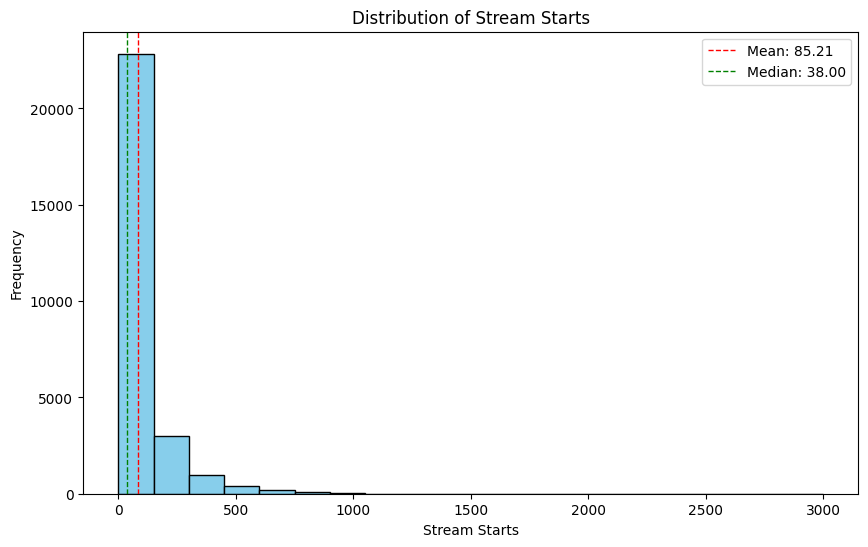

count   27,494.00
mean        85.21
std        126.96
min          0.00
25%         14.00
50%         38.00
75%        102.00
max      2,999.00
Name: stream_starts, dtype: float64

In [56]:
plt.hist(data_df['stream_starts'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Stream Starts')
plt.ylabel('Frequency')
plt.title('Distribution of Stream Starts')
# Calculate mean and median
mean_val = np.mean(data_df['stream_starts'])
median_val = np.median(data_df['stream_starts'])

# Add vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()
data_df['stream_starts'].describe()

In [57]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['stream_starts']
churned_data = data_df[data_df['user_state'] == 'Churned']['stream_starts']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in number of stream starts between user states is statistically significant.")
else:
    print("There is no statistically significant difference in number of stream starts between user states.")

ANOVA Test Results:
F-Statistic: 1214.9557443589401
P-Value: 1.6134308451472677e-260
The difference in number of stream starts between user states is statistically significant.


___Payment Months___

Considering that the dataset pertains to new subscribers in January 2023, any payment months predating that period are deemed as outliers and have been eliminated from the dataset.

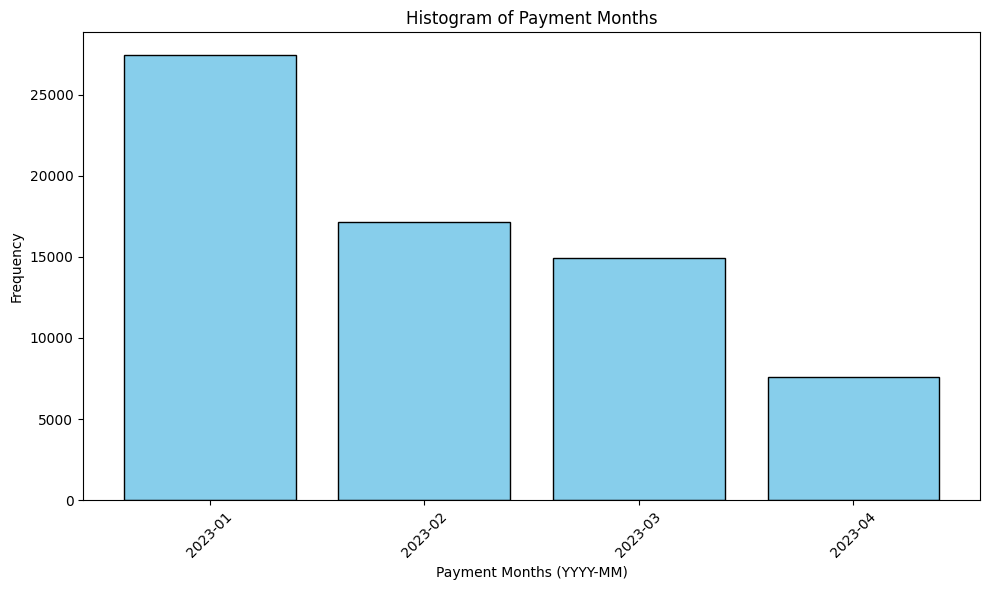

In [58]:
# Sum the values in each column to get the frequency of payments for each month
payment_months_4 = ['2023-01', '2023-02', '2023-03', '2023-04']
payment_counts = data_df[payment_months_4].sum().tolist()
payment_counts_series = pd.Series(payment_counts, index=payment_months_4)

plt.bar(payment_counts_series.index, payment_counts_series.values, color='skyblue', edgecolor='black')
plt.xlabel('Payment Months (YYYY-MM)')
plt.ylabel('Frequency')
plt.title('Histogram of Payment Months')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [59]:
payment_counts_df = pd.DataFrame({'Payment Months': payment_months_4, 'Frequency': payment_counts})

# Frequency Distribution
print("Frequency Distribution:")
print(payment_counts_df)

# Missing Values
missing_values = data_df[payment_months_4].isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Percentage Distribution
payment_counts_percentage = data_df[payment_months_4].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(payment_counts_percentage)

# Mode
payment_counts_mode = data_df[payment_months_4].mode()
print("\nMode of Category:")
print(payment_counts_mode)

Frequency Distribution:
  Payment Months  Frequency
0        2023-01      27475
1        2023-02      17141
2        2023-03      14930
3        2023-04       7615

Missing Values:
2023-01    0
2023-02    0
2023-03    0
2023-04    0
dtype: int64

Percentage Distribution:
2023-01  2023-02  2023-03  2023-04
1        0        0        0         32.60
         1        1        1         25.34
                           0         24.17
                  0        0         11.92
         0        1        0          3.58
                           1          1.16
         1        0        1          0.87
         0        0        1          0.29
0        1        1        1          0.02
                           0          0.01
         0        0        1          0.01
                  1        0          0.01
         1        0        0          0.01
         0        1        1          0.00
Name: proportion, dtype: float64

Mode of Category:
   2023-01  2023-02  2023-03  2023-04
0

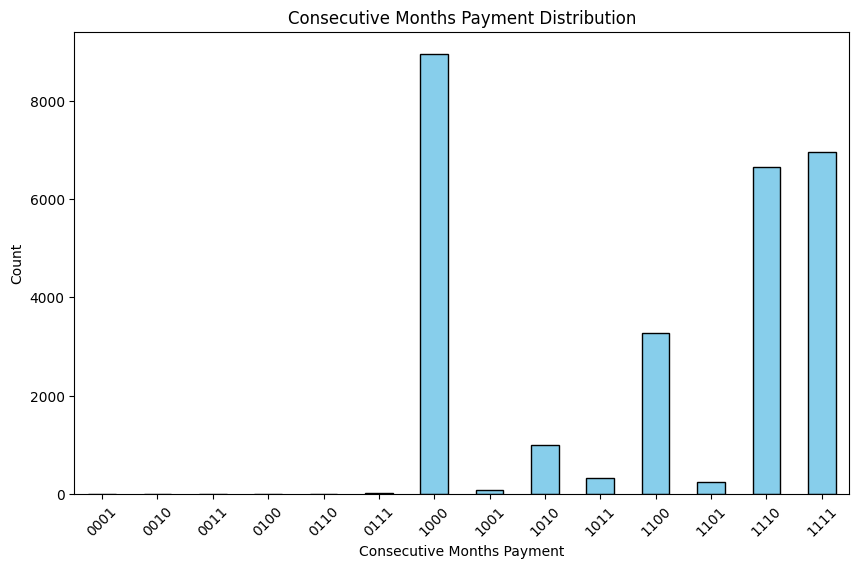

In [60]:
# Count occurrences for Consecutive Months Payment
consecutive_payment = data_df['consecutive_payments'].value_counts().sort_index()

consecutive_payment.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Consecutive Months Payment Distribution')
plt.xlabel('Consecutive Months Payment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

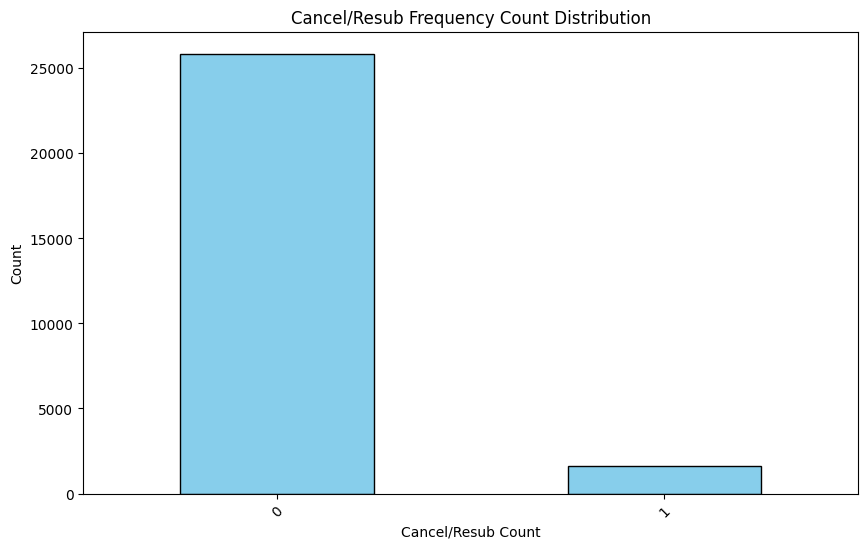

array([0, 1])

In [61]:
# Count occurrences for Cancel/Resub frequency Count
cancel_resub = data_df['cancel_resub_count'].value_counts().sort_index()

cancel_resub.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cancel/Resub Frequency Count Distribution')
plt.xlabel('Cancel/Resub Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

data_df['cancel_resub_count'].unique()

___Account Length___

__Observations__

The ANOVA test indicate that there is no statistically significant difference in account length between user states. 

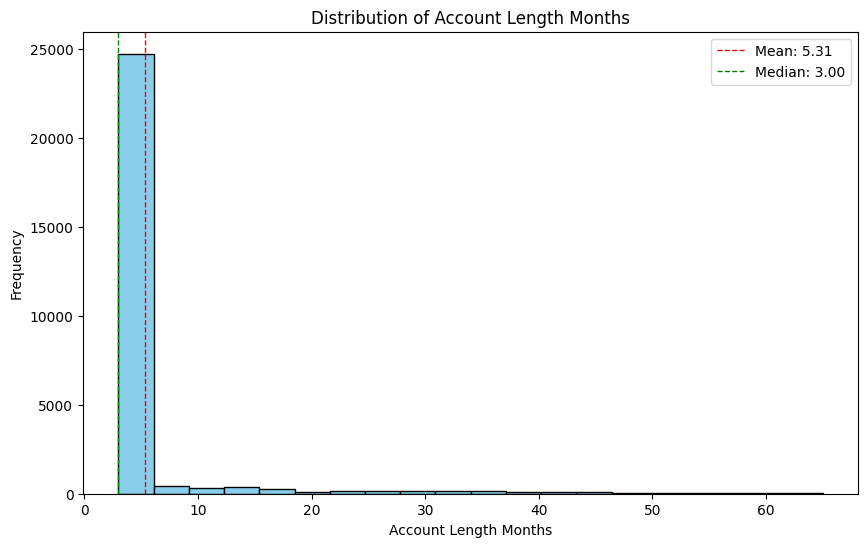

count   27,494.00
mean         5.31
std          7.37
min          3.00
25%          3.00
50%          3.00
75%          4.00
max         65.00
Name: account_length_months, dtype: float64

In [62]:
plt.hist(data_df['account_length_months'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Account Length Months')
plt.ylabel('Frequency')
plt.title('Distribution of Account Length Months')

# Calculate mean and median
mean_val = np.mean(data_df['account_length_months'])
median_val = np.median(data_df['account_length_months'])

plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

data_df['account_length_months'].describe()

In [63]:
# Filter data for different user states
active_data = data_df[data_df['user_state'] == 'Active']['account_length_months']
churned_data = data_df[data_df['user_state'] == 'Churned']['account_length_months']

# Perform ANOVA test
f_statistic, p_value = f_oneway(active_data, churned_data)

# Display the results
print("ANOVA Test Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in account length between user states is statistically significant.")
else:
    print("There is no statistically significant difference in account length between user states.")

ANOVA Test Results:
F-Statistic: 1.5937817367969662
P-Value: 0.20679736876478969
There is no statistically significant difference in account length between user states.


In [64]:
# Filter out accounts with more than 4 payments
data_df = data_df[data_df['total_payments'] <= 4]

In [65]:
# Filter out trial length more than 14 days
data_df = data_df[data_df['trial_length_days'] <= 14]

## Identifyling active and churned customers based on payment history

In [66]:
# Condition for first payment in the first half of January
cond_first_half_jan = (data_df['first_payment_at'].dt.month == 1) & (data_df['first_payment_at'].dt.day <= 15)

# Condition for first payment in the second half of January
cond_second_half_jan = (data_df['first_payment_at'].dt.month == 1) & (data_df['first_payment_at'].dt.day > 15)

payment_in_april = (data_df['2023-04'] == 1)
payment_in_march = (data_df['2023-03'] == 1)

active_customers = data_df[((cond_first_half_jan & payment_in_april) | (cond_second_half_jan & payment_in_march))]

num_active_customers = active_customers.shape[0]
num_churned_customers = data_df.shape[0] - num_active_customers
num_cancel_resub_customers = data_df[data_df['skipped_payments']==True]['account_id'].count()
total_num_customers = data_df.account_id.count()

print("Number of active customers:", num_active_customers)
print("No. of churned customers :", num_churned_customers)
print("No. of customers cancelled/resubscribed since January  :", num_cancel_resub_customers) 

Number of active customers: 13203
No. of churned customers : 13976
No. of customers cancelled/resubscribed since January  : 1610


In [67]:
# % of total customers churning
print("Total no. of customers :", total_num_customers)
perc_churn = num_churned_customers/total_num_customers*100
print(f"Percentage of customer churning : {round(perc_churn,2)}%")

perc_cancel_resub = num_cancel_resub_customers/total_num_customers*100
print(f"Percentage of customer who cancelled/resubscribed since January : {round(perc_cancel_resub,2)}%")

Total no. of customers : 27179
Percentage of customer churning : 51.42%
Percentage of customer who cancelled/resubscribed since January : 5.92%


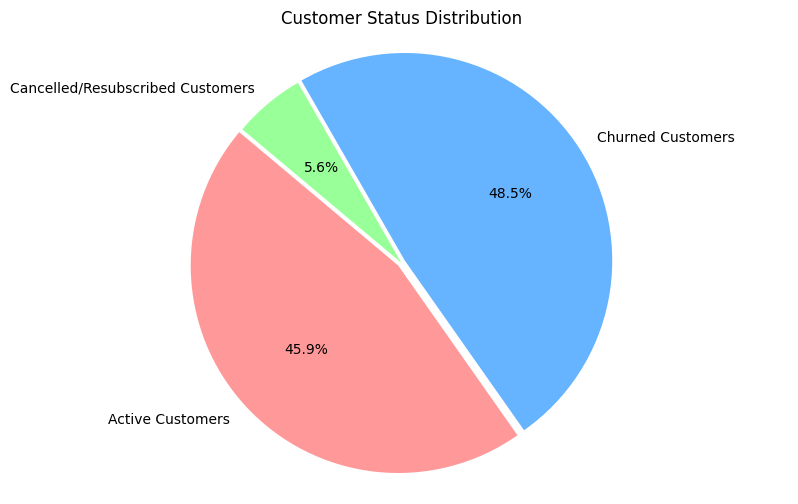

In [68]:
# plotting
labels = ['Active Customers', 'Churned Customers', 'Cancelled/Resubscribed Customers']
sizes = [num_active_customers, num_churned_customers, num_cancel_resub_customers]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.02, 0.02, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  

plt.title('Customer Status Distribution')
plt.show()

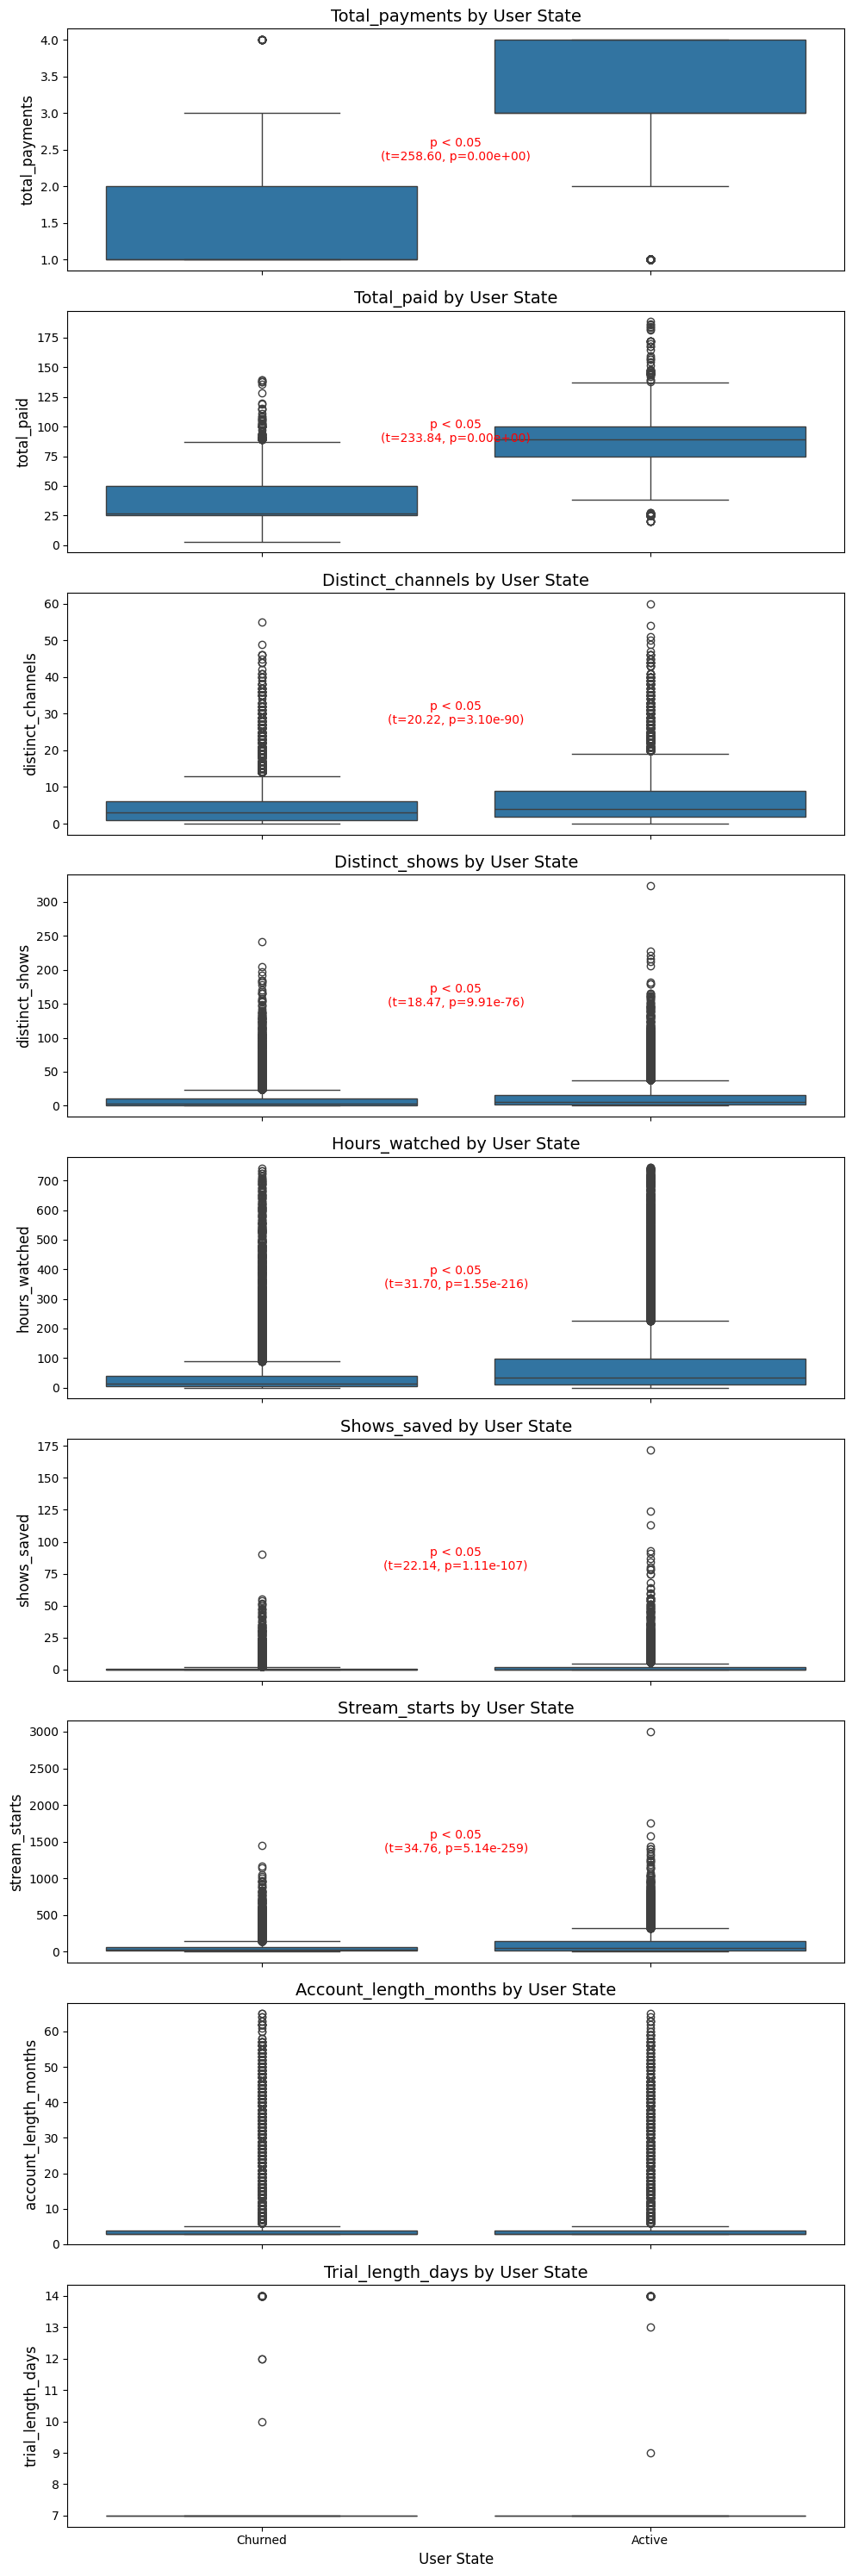

In [69]:
from scipy.stats import ttest_ind

# Define the metrics for visualization
metrics_to_visualize = ['total_payments', 'total_paid', 'distinct_channels', 'distinct_shows', 'hours_watched', 'shows_saved', 'stream_starts', 'account_length_months', 'trial_length_days']

fig, axs = plt.subplots(nrows=len(metrics_to_visualize), ncols=1, figsize=(10, 30), sharex=True)

for i, metric in enumerate(metrics_to_visualize):
    sns.boxplot(x='user_state', y=metric, data=data_df, ax=axs[i])
    axs[i].set_ylabel(metric, fontsize=12)
    axs[i].set_xlabel('User State', fontsize=12)
    axs[i].set_title(f'{metric.capitalize()} by User State', fontsize=14)

    # Perform t-test for significance
    active_data = data_df[data_df['user_state'] == 'Active'][metric]
    churned_data = data_df[data_df['user_state'] == 'Churned'][metric]
    t_stat, p_value = ttest_ind(active_data, churned_data)
    if p_value < 0.05:
        axs[i].annotate(f'p < 0.05\n(t={t_stat:.2f}, p={p_value:.2e})', 
                        xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

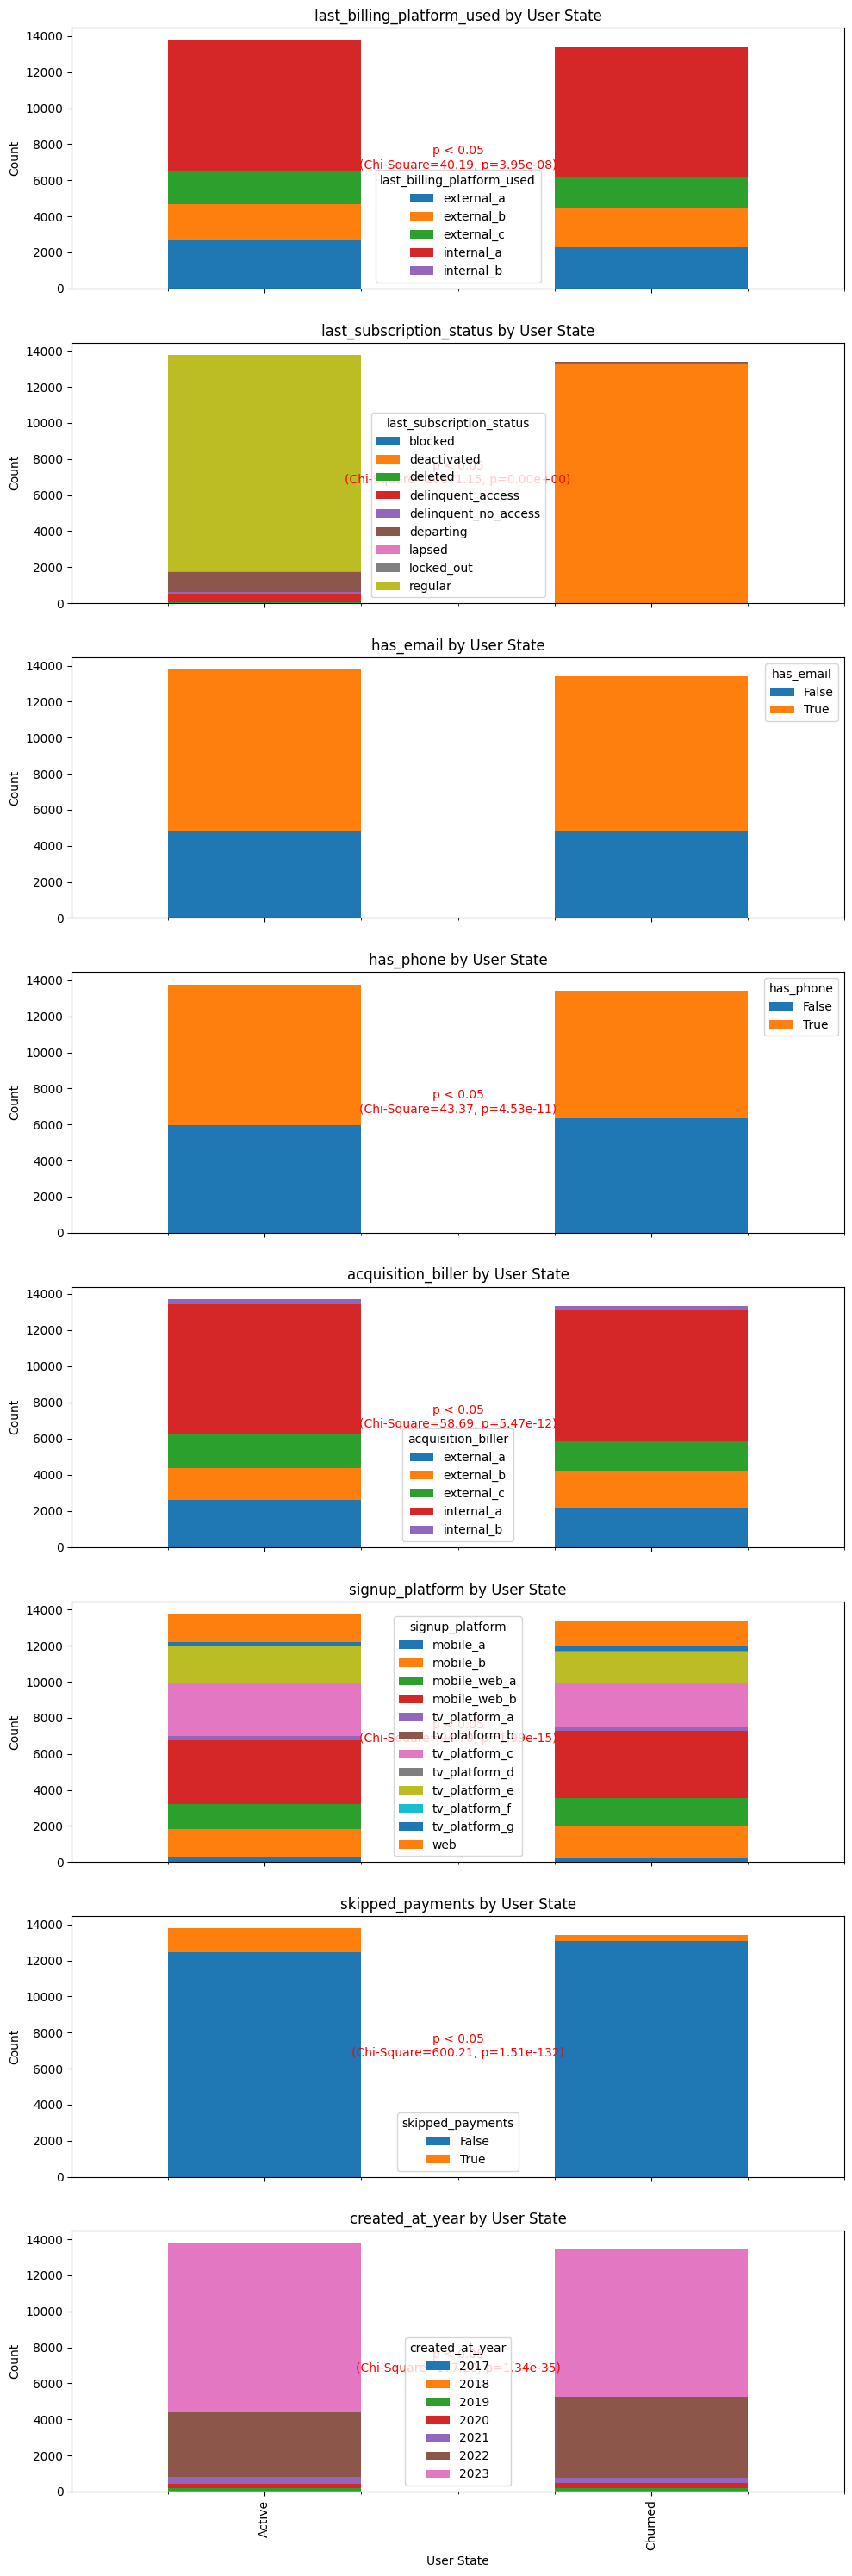

In [70]:
# Define the categorical variables for visualization
categorical_vars = ['last_billing_platform_used', 'last_subscription_status', 'has_email', 'has_phone', 'acquisition_biller', 'signup_platform', 'skipped_payments', 'created_at_year']

# Create subplots for each categorical variable
fig, axs = plt.subplots(nrows=len(categorical_vars), ncols=1, figsize=(10, 30), sharex=True)

# Loop through each categorical variable and create a stacked bar plot
for i, cat_var in enumerate(categorical_vars):
    crosstab = pd.crosstab(data_df['user_state'], data_df[cat_var])
    chi2_result = chi2_contingency(crosstab)
    
    # Stacked bar plot
    crosstab.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('User State')
    axs[i].set_title(f'{cat_var} by User State')

    # Add annotation for statistical significance
    if chi2_result[1] < 0.05:
        axs[i].annotate(f'p < 0.05\n(Chi-Square={chi2_result[0]:.2f}, p={chi2_result[1]:.2e})', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

## 5. Active/Churn Status Prediction

In this analysis, I am utilizing machine learning techniques to predict the churn/active status of users. 
The dataset undergoes several preprocessing steps to ensure its suitability for modeling:

1. ___Feature Selection___: Features that did not demonstrate a significant impact on the target variable (user_state) during the data exploration phase were removed.
   This step helps the model to focus on relevant information, potentially improving predictive performance.
2. ___Categorical Feature Encoding___: Categorical features are encoded to numerical representations using Label Encoding.
3. ___Handling Missing Data___: Rows with missing data are removed from the dataset.
   This ensures that the model is trained on complete and reliable information, minimizing the potential for biased predictions.

   
### Choice of Machine Learning Models:

Several machine learning models can be considered for predicting churn/active status, including Logistic Regression, Decision Trees, Support Vector Machines, and Random Forests, among others.

__Reason for Using Random Forest__:

I have chosen the Random Forest classifier for this task due to its ability to handle complex datasets with high dimensionality and non-linear relationships. 
Random Forests are an ensemble learning method that combines multiple decision trees, making them robust against overfitting and capable of capturing intricate patterns in the data. 
Additionally, Random Forests provide feature importance scores, allowing for insights into which features contribute most to the prediction.

__Hyperparameter Tuning with Grid Search__:

To optimize the Random Forest model's performance, I employ grid search, a technique for hyperparameter tuning. 
Grid search systematically explores a range of hyperparameter values and selects the combination that yields the best model performance based on a specified evaluation metric, such as accuracy or F1-score. 
This process helps fine-tune the model's parameters, enhancing its predictive capability on unseen data.

In [71]:
# Handle missing data
prediction_data = data_df.dropna()

# remove columns that have weak correlation with target value
columns_to_remove = ['account_id', 'has_email', 'trial_started_at', 'trial_ended_at', 'trial_ended_at', 'trial_length_days', 'account_length_months', 'payment_months', 'created_at_year_month', 'created_at_year_quarter', 'created_at_year']
prediction_data = prediction_data.drop(columns=columns_to_remove, errors='ignore')

In [72]:
# Convert datetime columns
prediction_data['created_at_year'] = prediction_data['created_at'].dt.year
prediction_data['first_payment_at_year'] = prediction_data['first_payment_at'].dt.year
prediction_data['first_payment_at_month'] = prediction_data['first_payment_at'].dt.month

# Drop unnecessary columns
prediction_data.drop(columns=['created_at'], inplace=True)  # Drop original datetime column
prediction_data.drop(columns=['first_payment_at'], inplace=True)  # Drop original datetime column

___Split Data into Train/Test/Validation Sets___

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = ['last_billing_platform_used', 'last_subscription_status', 'acquisition_biller', 'signup_platform', 'user_state', 'has_phone', 'first_payment_half_month']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns using LabelEncoder
for col in categorical_cols:
    prediction_data[col + '_encoded'] = label_encoder.fit_transform(prediction_data[col])

# Drop the original categorical columns
prediction_data.drop(categorical_cols, axis=1, inplace=True)

# Split data into features (X) and target variable (y)
X = prediction_data.drop('user_state_encoded', axis=1)
y = prediction_data['user_state_encoded']

# Split data into train/test sets (70% train, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split temporary data into validation/test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the sizes of the sets
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 18477
Validation set size: 3960
Test set size: 3960


___Apply ML Model for Prediction___

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import learning_curve

# Plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_model, "Learning Curve", X_train, y_train, cv=3)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model
print(classification_report(y_test, y_pred))

In [ ]:
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

In [ ]:
importances = best_model.feature_importances_

In [ ]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names based on feature importance ranking
names = [X.columns[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
feature_ranking = pd.DataFrame({'Feature': names, 'Importance': importances[indices]})
print(feature_ranking)

In [76]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27179 entries, 1 to 31460
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   account_id                  27179 non-null  int64         
 1   last_billing_platform_used  27179 non-null  object        
 2   last_subscription_status    27179 non-null  object        
 3   created_at                  27179 non-null  datetime64[ns]
 4   has_email                   27179 non-null  bool          
 5   has_phone                   27179 non-null  bool          
 6   user_state                  27179 non-null  object        
 7   total_payments              27179 non-null  float64       
 8   total_paid                  27179 non-null  float64       
 9   first_payment_at            27179 non-null  datetime64[ns]
 10  trial_started_at            27179 non-null  datetime64[ns]
 11  trial_ended_at              27179 non-null  datetime64[ns]


1. Filter the dataset to include only the relevant columns: "account_id", "user_state", and "created_at" (assuming this is the subscription start date).
2. Encode the churn event as a binary variable (0 for censored data, 1 for churned).
3. Sort the data by the subscription start date.
4. Calculate the Kaplan-Meier estimator to estimate the survival function, which represents the probability of survival (i.e., not churning) over time.

In [83]:
from lifelines import KaplanMeierFitter

# Filter relevant columns
df_subset = data_df[['account_id', 'user_state', 'created_at']]

# Encode churn event as binary variable (0 for censored, 1 for churned)
df_subset['churn'] = (df_subset['user_state'] == 'churned').astype(int)

# Sort data by subscription start date
df_subset = df_subset.sort_values(by='created_at')

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator
kmf.fit(durations=df_subset['created_at'], event_observed=df_subset['churn'])

# Estimate the survival function
survival_function = kmf.survival_function_

# Print the survival function
print(survival_function)

                              KM_estimate
timeline                                 
0.00                                 1.00
1,511,065,920,000,000,000.00         1.00
1,511,296,020,000,000,000.00         1.00
1,511,818,380,000,000,000.00         1.00
1,512,851,100,000,000,000.00         1.00
...                                   ...
1,675,053,600,000,000,000.00         1.00
1,675,129,320,000,000,000.00         1.00
1,675,130,460,000,000,000.00         1.00
1,675,186,380,000,000,000.00         1.00
1,675,206,720,000,000,000.00         1.00

[20328 rows x 1 columns]


/var/folders/bs/8mj02m5s0s947y78j3vj64dr0000gn/T/ipykernel_18223/49482036.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['churn'] = (df_subset['user_state'] == 'churned').astype(int)


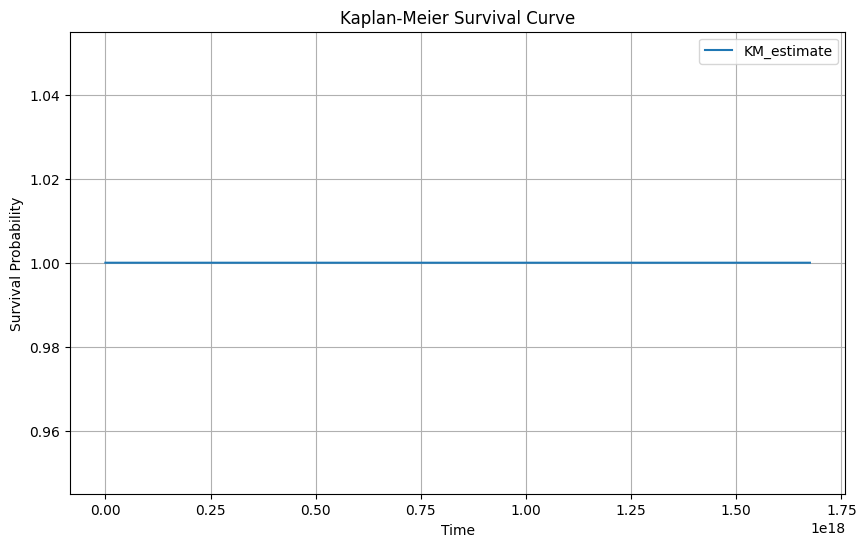

In [85]:
# Plot the survival function
survival_function.plot()
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curve')
plt.grid(True)
plt.show()